In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import linear_model, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import ensemble
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import average_precision_score,precision_recall_curve,auc,f1_score,accuracy_score

%matplotlib inline


In [ ]:
data_file = 'data/Dataset.xlsx'

In [2]:
####-------- Soc_Dem
Soc_Dem = pd.read_excel(r"data/Dataset.xlsx", sheetname="Soc_Dem")
#print(Soc_Dem.head())
print("Dimension of Soc Dem ", end='')
print(Soc_Dem.shape)

Dimension of Soc Dem (1615, 4)


In [3]:
###----- Products_ActBalance
Products_ActBalance = pd.read_excel(r"data/Dataset.xlsx", sheetname="Products_ActBalance")
#print(Products_ActBalance.head())
print("Dimension of Products_ActBalance ", end='')
print(Products_ActBalance.shape)

Dimension of Products_ActBalance (1615, 13)


In [4]:
###----- Inflow_Outflow
Inflow_Outflow = pd.read_excel(r"data/Dataset.xlsx", sheetname="Inflow_Outflow")
#print(Inflow_Outflow.head())
print("Dimension of Inflow_Outflow ", end='')
print(Inflow_Outflow.shape)


Dimension of Inflow_Outflow (1587, 15)


In [5]:
###----- Sales_Revenues
Sales_Revenues = pd.read_excel(r"data/Dataset.xlsx", sheetname="Sales_Revenues")
print("Dimension of Sales_Revenues ", end='')
print(Sales_Revenues.shape)

Dimension of Sales_Revenues (969, 7)


In [6]:
print(Soc_Dem[['Age','Tenure']].describe())

               Age       Tenure
count  1615.000000  1615.000000
mean     42.848916   101.339938
std      18.550529    64.917297
min       0.000000     0.000000
25%      29.000000    44.000000
50%      41.000000    97.000000
75%      57.000000   151.000000
max      97.000000   273.000000


In [7]:
# Age and Tenure have minimum values of 0
print(Soc_Dem[(Soc_Dem.Age == 0)])

# Client 158 has Age = 0 with Tenure = 152 => possible data error in Age value [replace age with average age]
mask = Soc_Dem.Age == 0
Soc_Dem['Age'] = np.where(mask, Soc_Dem.Age.mean(), Soc_Dem['Age'])

      Client Sex  Age  Tenure
1233     158   M    0     152


In [8]:
# Verify if there are other clients with their Age(in months) < Tenure
Soc_Dem_errors = Soc_Dem[Soc_Dem['Age']*12 < Soc_Dem['Tenure'] ]

print('Number of clients younger than their tenure at the Bank ', end='')
print(len(Soc_Dem_errors),'\n')

Number of clients younger than their tenure at the Bank 46 



In [9]:
print(Soc_Dem.isnull().sum())

Client    0
Sex       3
Age       0
Tenure    0
dtype: int64


3 clients have missing values in Sex attribute

In [10]:
sex_cross = pd.crosstab(index=Soc_Dem["Sex"], columns="count")
print(100*sex_cross/sex_cross.sum())

col_0      count
Sex             
F      46.898263
M      53.101737


53% of clients are male hence we replace missing values with male
less than 0.1% missing values hence unlikely to introduce bias hence simple imputation with the mode will suffice

In [11]:
Soc_Dem.replace(np.nan, 'M', inplace=True)

In [12]:
#Products_ActBalance.describe()

In [13]:
#print('\nCount missing Products_ActBalance')
#print(Products_ActBalance.isnull().sum())

Proportion of missing in the Product_ActBalance datasets

In [14]:
SA = Products_ActBalance[Products_ActBalance['Count_SA'].isnull()]
MF = Products_ActBalance[Products_ActBalance['Count_MF'].isnull()]
OVD = Products_ActBalance[Products_ActBalance['Count_OVD'].isnull()]
CC = Products_ActBalance[Products_ActBalance['Count_CC'].isnull()]
CL = Products_ActBalance[Products_ActBalance['Count_CL'].isnull()]

print("Proportion of missing values in Count_SA: ", 100*len(SA)/len(Products_ActBalance))
print("Proportion of missing values in Count_MF: ", 100*len(MF)/len(Products_ActBalance))
print("Proportion of missing values in Count_OVD: ", 100*len(OVD)/len(Products_ActBalance))
print("Proportion of missing values in Count_CC: ", 100*len(CC)/len(Products_ActBalance))
print("Proportion of missing values in Count_CL: ", 100*len(CL)/len(Products_ActBalance))

Proportion of missing values in Count_SA:  73.62229102167183
Proportion of missing values in Count_MF:  81.05263157894737
Proportion of missing values in Count_OVD:  74.05572755417957
Proportion of missing values in Count_CC:  89.47368421052632
Proportion of missing values in Count_CL:  91.64086687306502


we observe a univariate missing pattern between all Count_XX and ActBal_XX (XX = SA, MF, OVD, CC, CL)  
Investigate relationship between accounts and missing values 
first create dummy variables where 1 indicates the value is measured and 0 value is missing  
use this to perform statistical test. We used anon parametric test in order to avoid any distributional assumptions



In [15]:
Products_ActBalance['Count_SA_Dummy'] = Products_ActBalance['Count_SA']
Products_ActBalance["Count_SA_Dummy"].fillna(0,inplace=True)
Products_ActBalance["Count_SA_Dummy"] = np.where(Products_ActBalance.Count_SA_Dummy >= 1,1,Products_ActBalance["Count_SA_Dummy"])

Products_ActBalance['Count_MF_Dummy'] = Products_ActBalance['Count_MF']
Products_ActBalance["Count_MF_Dummy"].fillna(0,inplace=True)
Products_ActBalance["Count_MF_Dummy"] = np.where(Products_ActBalance.Count_MF_Dummy >= 1,1,Products_ActBalance["Count_MF_Dummy"])

Products_ActBalance['Count_OVD_Dummy'] = Products_ActBalance['Count_OVD']
Products_ActBalance["Count_OVD_Dummy"].fillna(0,inplace=True)
Products_ActBalance["Count_OVD_Dummy"] = np.where(Products_ActBalance.Count_OVD_Dummy >= 1,1,Products_ActBalance["Count_OVD_Dummy"])

Products_ActBalance['Count_CC_Dummy'] = Products_ActBalance['Count_CC']
Products_ActBalance["Count_CC_Dummy"].fillna(0,inplace=True)
Products_ActBalance["Count_CC_Dummy"] = np.where(Products_ActBalance.Count_CC_Dummy >= 1,1,Products_ActBalance["Count_CC_Dummy"])

Products_ActBalance['Count_CL_Dummy'] = Products_ActBalance['Count_CL']
Products_ActBalance["Count_CL_Dummy"].fillna(0,inplace=True)
Products_ActBalance["Count_CL_Dummy"] = np.where(Products_ActBalance.Count_CL_Dummy >= 1,1,Products_ActBalance["Count_CL_Dummy"])


##### Check mechanism of missing-ness in Count_SA varaible  
no significant difference in CA for clients with reported Count_SA  
differnence in pattern between those with reported Count_SA relative to those without for MF, OVD, CC and CL  
Those with reported Count_SA account tend to have higher ActBal_OVD  
Clients with reported Count_SA tend to have lower ActBal_CC and ActBal_CL than those without.  
A Similar but less obviouse was observed for ActBal_MF  


P value of wilcoxon-test on  ActBal_CA is 0.366781102403

P value of wilcoxon-test on  ActBal_MF is 4.58259488672e-10

P value of wilcoxon-test on  ActBal_OVD is 6.04649770917e-05

P value of wilcoxon-test on  ActBal_CC is 7.78127288593e-07

P value of wilcoxon-test on  ActBal_CL is 6.24216300598e-27


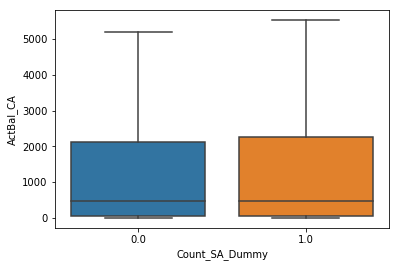

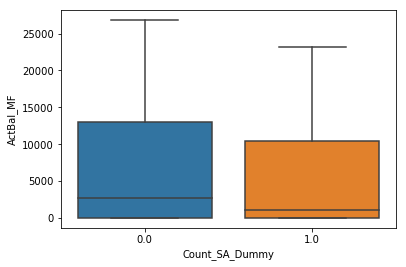

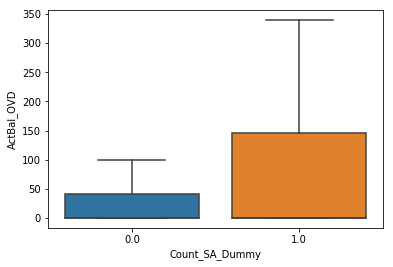

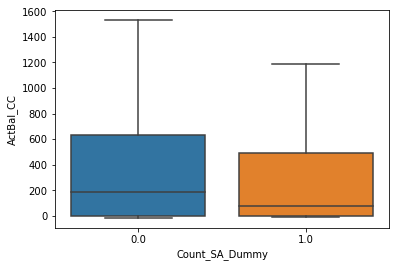

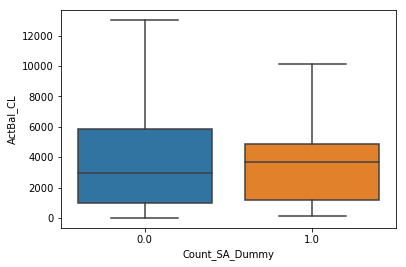

In [16]:

ActBal_colns = ['ActBal_CA','ActBal_MF', 'ActBal_OVD','ActBal_CC', 'ActBal_CL']

# no observable pattern between ActBal_CA and missing values in Count_SA
for colname in ActBal_colns:
    observed = Products_ActBalance[colname][Products_ActBalance.Count_SA_Dummy==1]
    missing = Products_ActBalance[colname][Products_ActBalance.Count_SA_Dummy==0]
    u, p_value = stats.mannwhitneyu(observed, missing)
    print ("\nP value of wilcoxon-test on ", colname, end=" is ")
    print (p_value)
    fig, ax = plt.subplots()
    b = sns.boxplot(x="Count_SA_Dummy", y=colname, data=Products_ActBalance, showfliers=False)
    #b = sns.boxplot(x="Count_SA_Dummy", y="ActBal_MF", data=Products_ActBalance)
    b.set_xlabel("Count_SA_Dummy")
    b.set_ylabel(colname)
    


##### Missingness on Count_MF  
clients with reported Count_MF tend to have higher ActBal_CL than those without


P value of wilcoxon-test on  ActBal_CA is 0.0332707830131

P value of wilcoxon-test on  ActBal_SA is 6.65922839235e-21

P value of wilcoxon-test on  ActBal_OVD is 0.161401722326

P value of wilcoxon-test on  ActBal_CC is 5.28655096339e-08

P value of wilcoxon-test on  ActBal_CL is 1.60557359778e-16


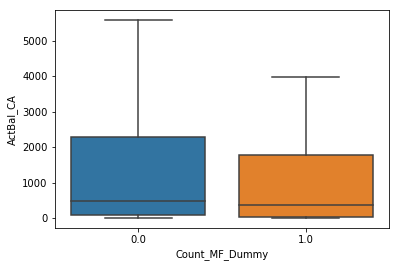

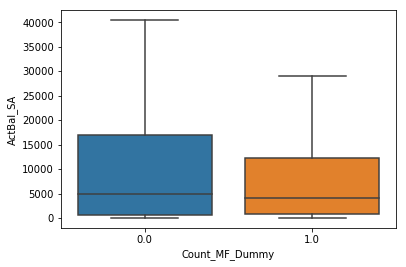

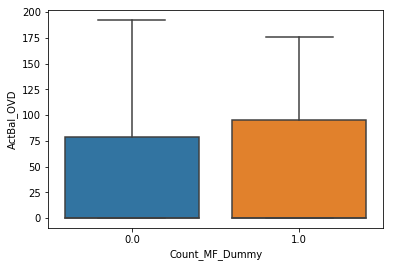

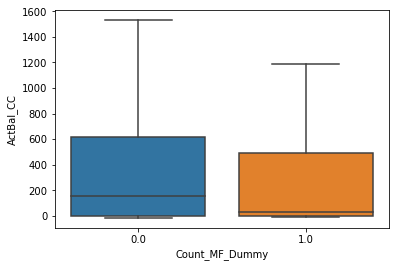

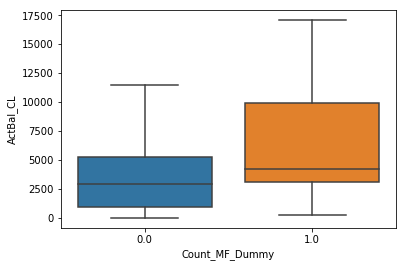

In [17]:
ActBal_colns = ['ActBal_CA', 'ActBal_SA', 'ActBal_OVD','ActBal_CC', 'ActBal_CL']

for colname in ActBal_colns:
    observed = Products_ActBalance[colname][Products_ActBalance.Count_MF_Dummy==1]
    missing = Products_ActBalance[colname][Products_ActBalance.Count_MF_Dummy==0]
    u, p_value = stats.mannwhitneyu(observed, missing)
    print ("\nP value of wilcoxon-test on ", colname, end=" is ")
    print (p_value)
    fig, ax = plt.subplots()
    b = sns.boxplot(x="Count_MF_Dummy", y=colname, data=Products_ActBalance, showfliers=False)
    b.set_xlabel("Count_MF_Dummy")
    b.set_ylabel(colname)
    


##### Messingness on OVD


P value of wilcoxon-test on  ActBal_CA is 0.181791218731

P value of wilcoxon-test on  ActBal_SA is 0.000121575577137

P value of wilcoxon-test on  ActBal_MF is 1.95955953929e-09

P value of wilcoxon-test on  ActBal_CC is 0.0103097756784

P value of wilcoxon-test on  ActBal_CL is 9.68417425113e-06


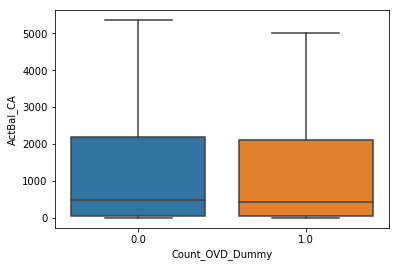

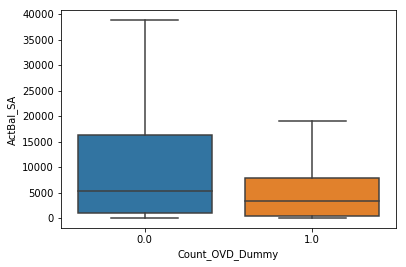

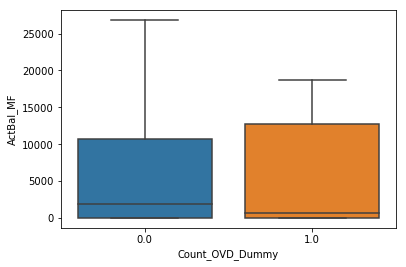

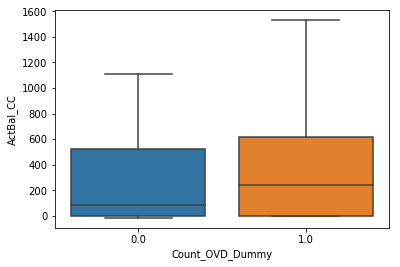

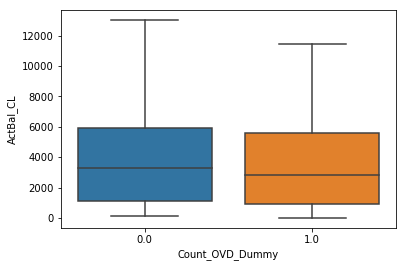

In [18]:

ActBal_colns = ['ActBal_CA', 'ActBal_SA', 'ActBal_MF','ActBal_CC', 'ActBal_CL']

for colname in ActBal_colns:
    observed = Products_ActBalance[colname][Products_ActBalance.Count_OVD_Dummy==1]
    missing = Products_ActBalance[colname][Products_ActBalance.Count_OVD_Dummy==0]
    u, p_value = stats.mannwhitneyu(observed, missing)
    print ("\nP value of wilcoxon-test on ", colname, end=" is ")
    print (p_value)
    fig, ax = plt.subplots()
    b = sns.boxplot(x="Count_OVD_Dummy", y=colname, data=Products_ActBalance, showfliers=False)
    b.set_xlabel("Count_OVD_Dummy")
    b.set_ylabel(colname)

Create dummy Count_CC variable to check any association of missingness to the response


P value of wilcoxon-test on  ActBal_CA is 0.00666440009397

P value of wilcoxon-test on  ActBal_SA is 0.165289658651

P value of wilcoxon-test on  ActBal_MF is 0.00149403799579

P value of wilcoxon-test on  ActBal_OVD is 1.20968911939e-06

P value of wilcoxon-test on  ActBal_CL is 0.0347572569624


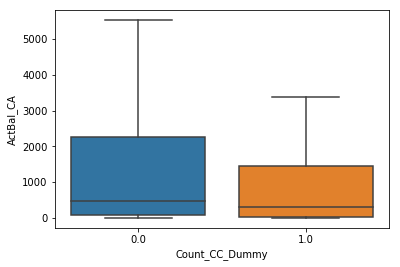

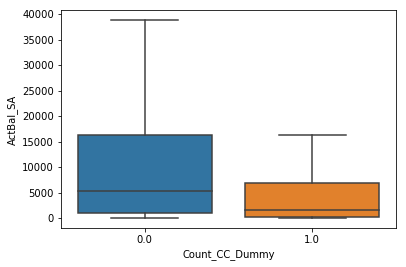

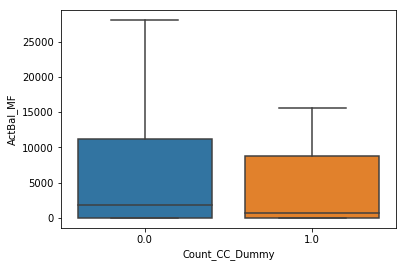

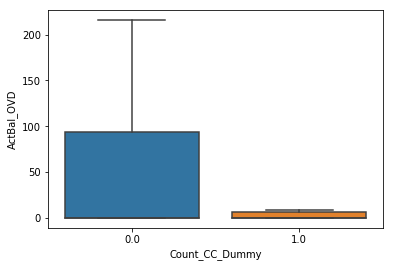

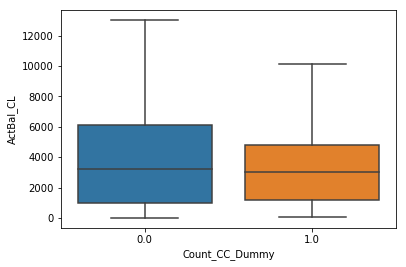

In [19]:

ActBal_colns = ['ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CL']

for colname in ActBal_colns:
    observed = Products_ActBalance[colname][Products_ActBalance.Count_CC_Dummy==1]
    missing = Products_ActBalance[colname][Products_ActBalance.Count_CC_Dummy==0]
    u, p_value = stats.mannwhitneyu(observed, missing)
    print ("\nP value of wilcoxon-test on ", colname, end=" is ")
    print (p_value)
    fig, ax = plt.subplots()
    b = sns.boxplot(x="Count_CC_Dummy", y=colname, data=Products_ActBalance, showfliers=False)
    b.set_xlabel("Count_CC_Dummy")
    b.set_ylabel(colname)

Create dummy Count_CL variable to check any association of missingness to the response


P value of wilcoxon-test on  ActBal_CA is 0.38378006844

P value of wilcoxon-test on  ActBal_SA is 1.73742696668e-07

P value of wilcoxon-test on  ActBal_MF is 1.16564542629e-10

P value of wilcoxon-test on  ActBal_OVD is 2.21848148434e-14

P value of wilcoxon-test on  ActBal_CC is 0.334016347421


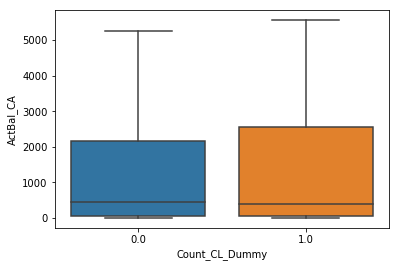

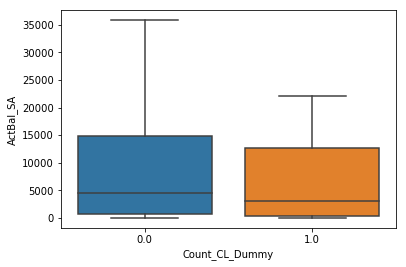

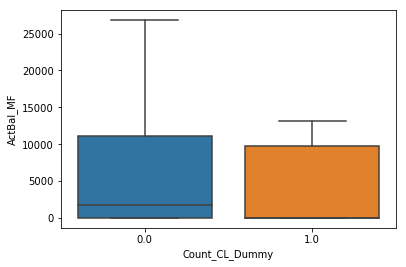

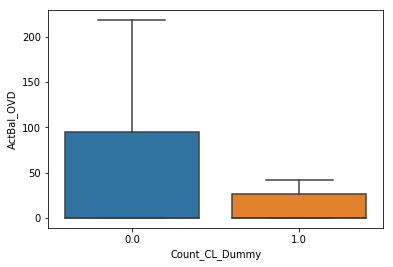

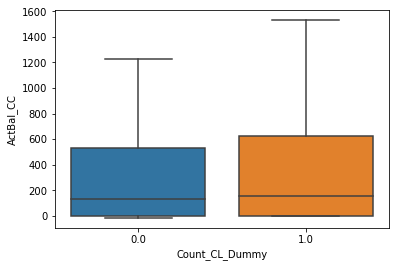

In [20]:
## Check dummy Count_CL
ActBal_colns = ['ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD','ActBal_CC']

for colname in ActBal_colns:
    observed = Products_ActBalance[colname][Products_ActBalance.Count_CL_Dummy==1]
    missing = Products_ActBalance[colname][Products_ActBalance.Count_CL_Dummy==0]
    u, p_value = stats.mannwhitneyu(observed, missing)
    print ("\nP value of wilcoxon-test on ", colname, end=" is ")
    print (p_value)
    fig, ax = plt.subplots()
    b = sns.boxplot(x="Count_CL_Dummy", y=colname, data=Products_ActBalance, showfliers=False)
    b.set_xlabel("Count_CL_Dummy")
    b.set_ylabel(colname)

##### check if missingness is associated to response  
We create dummy indicators and use their interaction in the model  
though this technique has been reported to introduce bias [PMID: 7503045]  

In [21]:


# Create interaction variable
Products_ActBalance['ActBal_SA_Dummy'] = Products_ActBalance['ActBal_SA']
Products_ActBalance["ActBal_SA_Dummy"].fillna(0,inplace=True)
Products_ActBalance["ActBal_SA_interaction"] = Products_ActBalance["ActBal_SA_Dummy"]*Products_ActBalance["Count_SA_Dummy"]

Products_ActBalance['ActBal_MF_Dummy'] = Products_ActBalance['ActBal_MF']
Products_ActBalance["ActBal_MF_Dummy"].fillna(0,inplace=True)
Products_ActBalance["ActBal_MF_interaction"] = Products_ActBalance["ActBal_MF_Dummy"]*Products_ActBalance["Count_MF_Dummy"]

Products_ActBalance['ActBal_OVD_Dummy'] = Products_ActBalance['ActBal_OVD']
Products_ActBalance["ActBal_OVD_Dummy"].fillna(0,inplace=True)
Products_ActBalance["ActBal_OVD_interaction"] = Products_ActBalance["ActBal_OVD_Dummy"]*Products_ActBalance["Count_OVD_Dummy"]

Products_ActBalance['ActBal_CC_Dummy'] = Products_ActBalance['ActBal_CC']
Products_ActBalance["ActBal_CC_Dummy"].fillna(0,inplace=True)
Products_ActBalance["ActBal_CC_interaction"] = Products_ActBalance["ActBal_CC_Dummy"]*Products_ActBalance["Count_CC_Dummy"]

Products_ActBalance['ActBal_CL_Dummy'] = Products_ActBalance['ActBal_CL']
Products_ActBalance["ActBal_CL_Dummy"].fillna(0,inplace=True)
Products_ActBalance["ActBal_CL_interaction"] = Products_ActBalance["ActBal_CL_Dummy"]*Products_ActBalance["Count_CL_Dummy"]

In [22]:
Inflow_Outflow.describe()

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000
mean,808.174543,1823.559572,1506.329113,5.541903,4.265280,1697.218658,1460.202903,257.937337,150.850401,715.974931,16.006931,13.596723,1.988658,5.240076,4.601134
std,466.744374,5864.792552,4661.535696,6.355383,4.944032,5183.787844,4281.369956,757.734230,311.938796,3215.106760,16.243554,12.975287,2.710704,8.386154,5.211451
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,405.500000,252.923393,214.290893,2.000000,2.000000,226.214286,211.848750,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000
50%,808.000000,655.867500,620.858214,3.000000,3.000000,654.615357,632.148929,71.428571,20.139286,175.428571,11.000000,10.000000,1.000000,1.000000,3.000000
75%,1213.500000,1426.027143,1304.757143,6.000000,4.000000,1418.208214,1329.007857,353.370536,175.892500,507.607143,22.000000,19.000000,3.000000,7.000000,7.000000
max,1615.000000,107703.804286,98717.675000,63.000000,48.000000,119906.503929,73477.932500,23571.428571,3637.616786,72278.782143,102.000000,83.000000,25.000000,60.000000,34.000000


In [23]:
#print('\nCount missing Inflow_Outflow')
#print(Inflow_Outflow.isnull().sum())

Merge datasets

In [24]:
Soc_Dem_Products_ActBalance = pd.merge(Soc_Dem, Products_ActBalance, on='Client', how='outer')
market_data = pd.merge(Soc_Dem_Products_ActBalance, Inflow_Outflow, on='Client', how='outer')

Convert Sex characters to Male=1 and Female=0

In [ ]:
market_data["Sex_Dummy"] = np.where(market_data.Sex=='M',1,0)

In [25]:
#print(market_data.isnull().sum())

##### Impute missing values using simple imputation  
The merged market_data dataset has about 2% missing values for inflow_outflow variable  
we replace all missing continuous values with their corresponding mean  

In [26]:

int_col = ['VolumeCred','VolumeCred_CA','VolumeDeb','VolumeDeb_CA','VolumeDebCash_Card',
           'VolumeDebCashless_Card','VolumeDeb_PaymentOrder']
for col_name in int_col:
    mean = market_data[col_name].mean()
    market_data[col_name] = market_data[col_name].fillna(mean)

In [27]:
# replace missing values by rounded mean
int_col = ['TransactionsCred','TransactionsCred_CA','TransactionsDeb','TransactionsDeb_CA','TransactionsDebCash_Card','TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']
for col_name in int_col:
    mean = round(market_data[col_name].mean())
    market_data[col_name] = market_data[col_name].fillna(mean)
    market_data[col_name] = market_data[col_name].astype(np.int64)

##### Check missing-ness relative to inflow_outflow varaibles

In [29]:

dummy_col = ['Count_SA_Dummy','Count_MF_Dummy', 'Count_OVD_Dummy', 'Count_CC_Dummy', 'Count_CL_Dummy',]
in_out_col = ['VolumeCred', 'VolumeCred_CA','TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA','VolumeDebCash_Card', 'VolumeDebCashless_Card','VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA','TransactionsDebCash_Card', 'TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder',]

print('features related to missing ness')

## Check dummy Count_CL
for col1 in dummy_col:
    for col2 in in_out_col:
        observed = market_data[col2][market_data[col1]==1]
        missing = market_data[col2][market_data[col1]==0]
        u, p_value = stats.mannwhitneyu(observed, missing)
        if (p_value < 0.05):
            print ("\nP value of wilcoxon-test on ", col1, " vs ",col2, end=" is ")
            print (p_value)

features related to missing ness

P value of wilcoxon-test on  Count_SA_Dummy  vs  VolumeCred is 3.69268085348e-07

P value of wilcoxon-test on  Count_SA_Dummy  vs  VolumeCred_CA is 0.000844870068123

P value of wilcoxon-test on  Count_SA_Dummy  vs  TransactionsCred is 1.53480429453e-17

P value of wilcoxon-test on  Count_SA_Dummy  vs  VolumeDeb is 0.000382171901458

P value of wilcoxon-test on  Count_SA_Dummy  vs  VolumeDeb_CA is 0.00192631568831

P value of wilcoxon-test on  Count_SA_Dummy  vs  VolumeDebCash_Card is 0.041609147717

P value of wilcoxon-test on  Count_SA_Dummy  vs  VolumeDeb_PaymentOrder is 2.89804218995e-07

P value of wilcoxon-test on  Count_SA_Dummy  vs  TransactionsDebCash_Card is 0.000158318684481

P value of wilcoxon-test on  Count_SA_Dummy  vs  TransactionsDeb_PaymentOrder is 2.49754932917e-06

P value of wilcoxon-test on  Count_MF_Dummy  vs  VolumeCred is 8.896095746e-06

P value of wilcoxon-test on  Count_MF_Dummy  vs  VolumeCred_CA is 6.6032199965e-05

P valu

distribution of ActBal_SA across the number of accounts

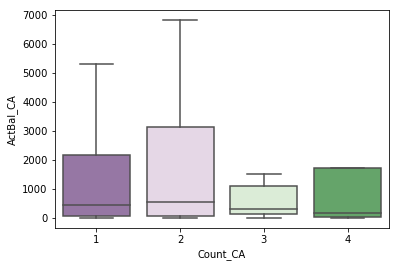

In [30]:
sns.boxplot(x="Count_CA", y="ActBal_CA", data=market_data, palette="PRGn", showfliers=False)

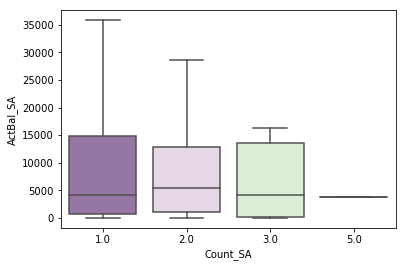

In [31]:
sns.boxplot(x="Count_SA", y="ActBal_SA", data=market_data, palette="PRGn", showfliers=False)

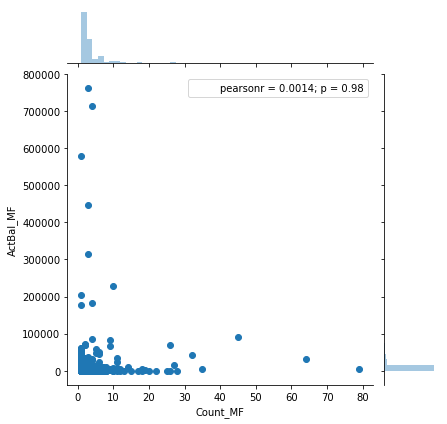

In [32]:
sns.jointplot(x="Count_MF", y="ActBal_MF", data=market_data)

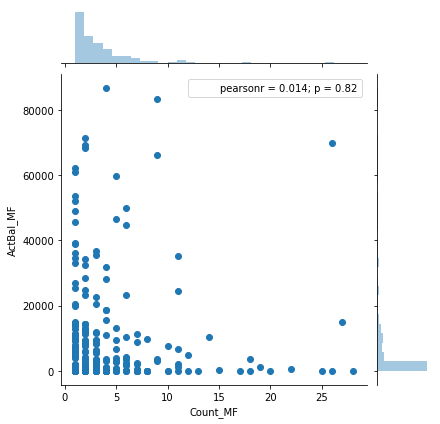

In [33]:
# check influence of outliers
market_data_MF = market_data[(market_data['Count_MF'] < 30) & (market_data['ActBal_MF'] < 100000)]
sns.jointplot(x="Count_MF", y="ActBal_MF", data=market_data_MF)

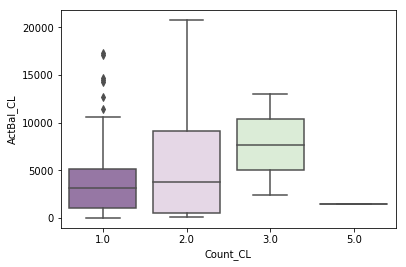

In [34]:
sns.boxplot(x="Count_CL", y="ActBal_CL", data=market_data, palette="PRGn")

## Missing values in Social demography

Sex               F    M   All
Count_SA_Dummy                
0.0             542  647  1189
1.0             214  212   426
All             756  859  1615

Chi square test on Sex
Chi value:  2.72392694071 	p value:  0.6050342456

two-sample wilcoxon-test Tenure on
p value  0.192052022254

two-sample wilcoxon-test Age on
p value  0.0287548598936


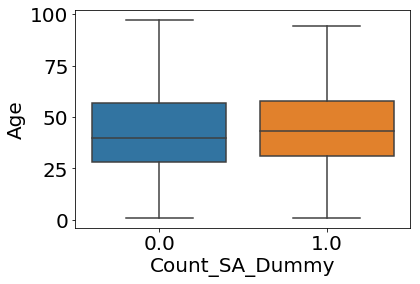

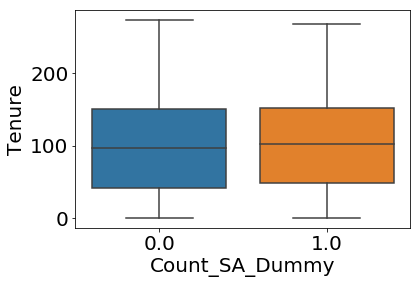

In [35]:

# Sex
sex_tab = pd.crosstab(market_data['Count_SA_Dummy'], market_data['Sex'], margins = True)
print(sex_tab)
chi = stats.chi2_contingency(sex_tab)
print ("\nChi square test on Sex")
print("Chi value: ", chi[0], "\tp value: ", chi[1])

# Age
font = 20
fig, ax = plt.subplots()
b = sns.boxplot(x="Count_SA_Dummy", y="Age", data=market_data)
b.set_xlabel("Count_SA_Dummy",fontsize=font)
b.set_ylabel("Age",fontsize=font)
b.tick_params(labelsize=font)

fig, ax = plt.subplots()
b = sns.boxplot(x="Count_SA_Dummy", y="Tenure", data=market_data)
b.set_xlabel("Count_SA_Dummy",fontsize=font)
b.set_ylabel("Tenure",fontsize=font)
b.tick_params(labelsize=font)

observed = market_data.Tenure[market_data.Count_SA_Dummy==1]
missing = market_data.Tenure[market_data.Count_SA_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Tenure on")
print ("p value ", p_value)

observed = market_data.Age[market_data.Count_SA_Dummy==1]
missing = market_data.Age[market_data.Count_SA_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Age on")
print ("p value ", p_value)

## Missing values in Mutual Fund

Sex_Dummy         0    1   All
Count_MF_Dummy                
0.0             613  696  1309
1.0             143  163   306
All             756  859  1615

Chi square test on Sex

Chi value:  0.000949183126225 	p value:  0.999999887417

two-sample wilcoxon-test Tenure on
p value  0.311412290541

two-sample wilcoxon-test Age on
p value  0.396318465688


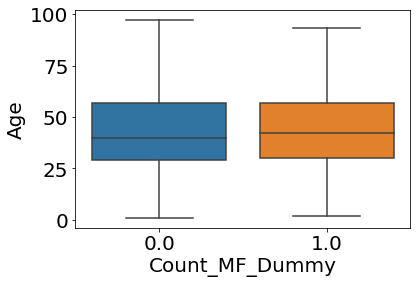

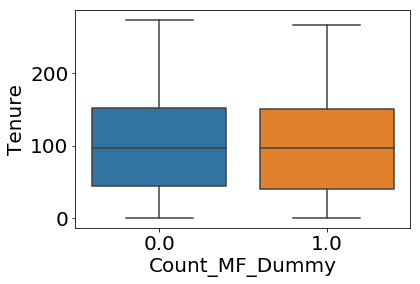

In [36]:
# Sex
sex_tab = pd.crosstab(market_data['Count_MF_Dummy'], market_data['Sex_Dummy'], margins = True)
print(sex_tab)
chi = stats.chi2_contingency(sex_tab)
print ("\nChi square test on Sex")
print("\nChi value: ", chi[0], "\tp value: ", chi[1])

# P value 0.999 > 0.05 indicating there is significant difference in missinge between s

# Age
font = 20
fig, ax = plt.subplots()
b = sns.boxplot(x="Count_MF_Dummy", y="Age", data=market_data)
b.set_xlabel("Count_MF_Dummy",fontsize=font)
b.set_ylabel("Age",fontsize=font)
b.tick_params(labelsize=font)

# Tenure
fig, ax = plt.subplots()
b = sns.boxplot(x="Count_MF_Dummy", y="Tenure", data=market_data)
b.set_xlabel("Count_MF_Dummy",fontsize=font)
b.set_ylabel("Tenure",fontsize=font)
b.tick_params(labelsize=font)

observed = market_data.Tenure[market_data.Count_MF_Dummy==1]
missing = market_data.Tenure[market_data.Count_MF_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Tenure on")
print ("p value ", p_value)

observed = market_data.Age[market_data.Count_MF_Dummy==1]
missing = market_data.Age[market_data.Count_MF_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Age on")
print ("p value ", p_value)

## missing values in Consumer Loan

Sex_Dummy         0    1   All
Count_CL_Dummy                
0.0             701  779  1480
1.0              55   80   135
All             756  859  1615

Chi square test on Sex
Chi value:  2.18026847223 	p value:  0.702643277808

two-sample wilcoxon-test Tenure on
p value  0.386395615697

two-sample wilcoxon-test Age on
p value  0.281712854488


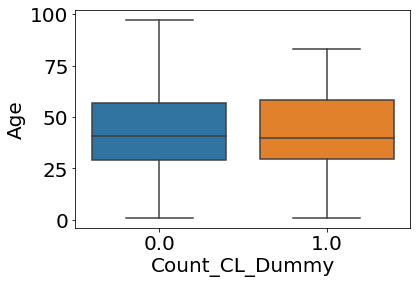

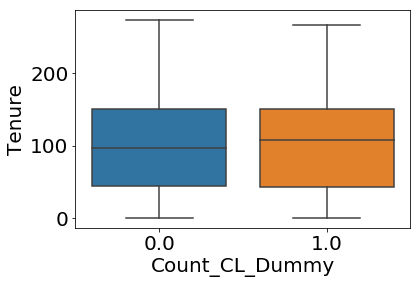

In [37]:
# Sex
sex_tab = pd.crosstab(market_data['Count_CL_Dummy'], market_data['Sex_Dummy'], margins = True)
print(sex_tab)
chi = stats.chi2_contingency(sex_tab)
print ("\nChi square test on Sex")
print("Chi value: ", chi[0], "\tp value: ", chi[1])

# Age
font = 20
b = sns.boxplot(x="Count_CL_Dummy", y="Age", data=market_data)
b.axes.set_title(" ", fontsize=font)
b.set_xlabel("Count_CL_Dummy",fontsize=font)
b.set_ylabel("Age",fontsize=font)
b.tick_params(labelsize=font)

fig, ax = plt.subplots()
b = sns.boxplot(x="Count_CL_Dummy", y="Tenure", data=market_data)
b.set_xlabel("Count_CL_Dummy",fontsize=font)
b.set_ylabel("Tenure",fontsize=font)
b.tick_params(labelsize=font)

observed = market_data.Tenure[market_data.Count_CL_Dummy==1]
missing = market_data.Tenure[market_data.Count_CL_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Tenure on")
print ("p value ", p_value)

observed = market_data.Age[market_data.Count_CL_Dummy==1]
missing = market_data.Age[market_data.Count_CL_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Age on")
print ("p value ", p_value)

## Missing value in Credit card

Sex               F    M   All
Count_CC_Dummy                
0.0             677  768  1445
1.0              79   91   170
All             756  859  1615

Chi value:  0.00885042284926 	p value:  0.99999023759

two-sample wilcoxon-test Tenure on
p value  0.365118322452

two-sample wilcoxon-test Age on
p value  0.0599516446171


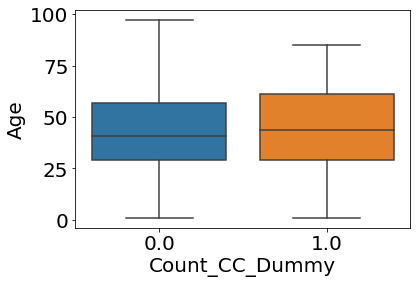

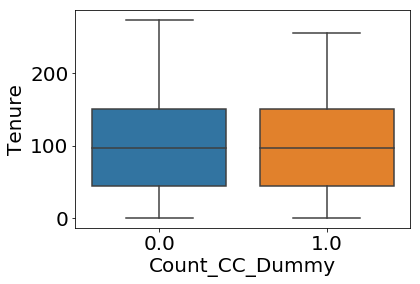

In [38]:
# Sex
sex_tab = pd.crosstab(market_data['Count_CC_Dummy'], market_data['Sex'], margins = True)
print(sex_tab)
chi = stats.chi2_contingency(sex_tab)
print("\nChi value: ", chi[0], "\tp value: ", chi[1])

# Age
font = 20
b = sns.boxplot(x="Count_CC_Dummy", y="Age", data=market_data)
b.axes.set_title(" ", fontsize=font)
b.set_xlabel("Count_CC_Dummy",fontsize=font)
b.set_ylabel("Age",fontsize=font)
b.tick_params(labelsize=font)

fig, ax = plt.subplots()
b = sns.boxplot(x="Count_CC_Dummy", y="Tenure", data=market_data)
b.set_xlabel("Count_CC_Dummy",fontsize=font)
b.set_ylabel("Tenure",fontsize=font)
b.tick_params(labelsize=font)

observed = market_data.Tenure[market_data.Count_CC_Dummy==1]
missing = market_data.Tenure[market_data.Count_CC_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Tenure on")
print ("p value ", p_value)

observed = market_data.Age[market_data.Count_CC_Dummy==1]
missing = market_data.Age[market_data.Count_CC_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Age on")
print ("p value ", p_value)

Sex                F    M   All
Count_OVD_Dummy                
0.0              566  630  1196
1.0              190  229   419
All              756  859  1615

Chi value:  0.487764505754 	p value:  0.97468112275

two-sample wilcoxon-test Tenure on
p value  0.288190588477

two-sample wilcoxon-test Age on
p value  0.298806997458


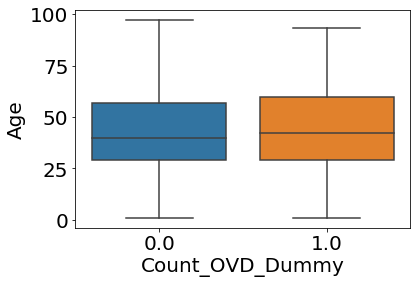

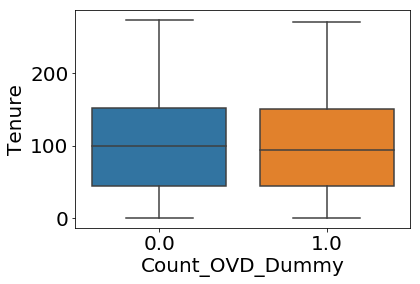

In [39]:
# Sex
sex_tab = pd.crosstab(market_data['Count_OVD_Dummy'], market_data['Sex'], margins = True)
print(sex_tab)
chi = stats.chi2_contingency(sex_tab)
print("\nChi value: ", chi[0], "\tp value: ", chi[1])

# Age 
font = 20
fig, ax = plt.subplots()
b = sns.boxplot(x="Count_OVD_Dummy", y="Age", data=market_data)
b.set_xlabel("Count_OVD_Dummy",fontsize=font)
b.set_ylabel("Age",fontsize=font)
b.tick_params(labelsize=font)

fig, ax = plt.subplots()
b = sns.boxplot(x="Count_OVD_Dummy", y="Tenure", data=market_data)
b.set_xlabel("Count_OVD_Dummy",fontsize=font)
b.set_ylabel("Tenure",fontsize=font)
b.tick_params(labelsize=font)

observed = market_data.Tenure[market_data.Count_OVD_Dummy==1]
missing = market_data.Tenure[market_data.Count_OVD_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Tenure on")
print ("p value ", p_value)

observed = market_data.Age[market_data.Count_OVD_Dummy==1]
missing = market_data.Age[market_data.Count_OVD_Dummy==0]
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Age on")
print ("p value ", p_value)

In [40]:
######---------- Feature Selection ----------######

# merge Revenue data to obtain training set
train = pd.merge(Sales_Revenues, market_data, on='Client')
print(train.shape)


(969, 52)


In [41]:
# Proportion of missing in the Product_ActBalance datasets
SA_t = train[train['Count_SA'].isnull()]
MF_t = train[train['Count_MF'].isnull()]
OVD_t = train[train['Count_OVD'].isnull()]
CC_t = train[train['Count_CC'].isnull()]
CL_t = train[train['Count_CL'].isnull()]

print("Proportion of missing values in Count_SA: ", 100*len(SA_t)/len(train))
print("Proportion of missing values in Count_MF: ", 100*len(MF_t)/len(train))
print("Proportion of missing values in Count_OVD: ", 100*len(OVD_t)/len(train))
print("Proportion of missing values in Count_CC: ", 100*len(CC_t)/len(train))
print("Proportion of missing values in Count_CL: ", 100*len(CL_t)/len(train))

# similar proportions of missingness in the training set

Proportion of missing values in Count_SA:  72.65221878224975
Proportion of missing values in Count_MF:  81.01135190918473
Proportion of missing values in Count_OVD:  74.09700722394221
Proportion of missing values in Count_CC:  88.64809081527348
Proportion of missing values in Count_CL:  91.84726522187823


Number of clients who did not buy MF: 776
Number of clients with missing value Count_MF/ActBal_MF: 785
Number of clients with missing value Count_MF/ActBal_MF but having Sale_MF: 143
Number of samples in observed  50
Number of samples in missing  143

two-sample wilcoxon-test Tenure on
p value  0.00540496597506


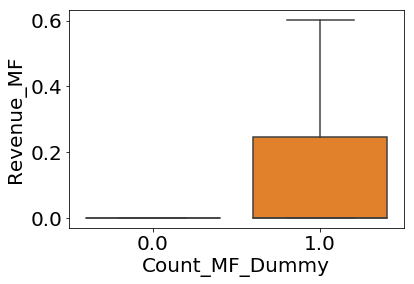

In [42]:
# investigate missing and response 
print('Number of clients who did not buy MF: ', end='')
print(len(train[train.Sale_MF==0]))

print('Number of clients with missing value Count_MF/ActBal_MF: ', end='')
print(len(train[train.Count_MF_Dummy==0]))

print('Number of clients with missing value Count_MF/ActBal_MF but having Sale_MF: ', end='')
Sale_MF_missing = train[(train.Count_MF_Dummy==0) & (train.Sale_MF==1)]
print(len(Sale_MF_missing))

b = sns.boxplot(x="Count_MF_Dummy", y="Revenue_MF", data=train, showfliers=False)
#b = sns.boxplot(x="Count_MF_Dummy", y="Revenue_MF", data=train)
b.axes.set_title(" ", fontsize=font)
b.set_xlabel("Count_MF_Dummy",fontsize=font)
b.set_ylabel("Revenue_MF",fontsize=font)
b.tick_params(labelsize=font)

observed = train.Revenue_MF[train.Count_MF_Dummy==1]
missing = train.Revenue_MF[train.Count_MF_Dummy==0]
print('Number of samples in observed ', len(observed[observed >0]))
print('Number of samples in missing ', len(missing[missing >0]))

u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Tenure on")
print ("p value ", p_value)

Number of clients with missing value Count_MF/ActBal_MF but having Sale_CC: 216
Number of samples in observed  49
Number of samples in missing  193

two-sample wilcoxon-test Tenure on
p value  0.290683420093


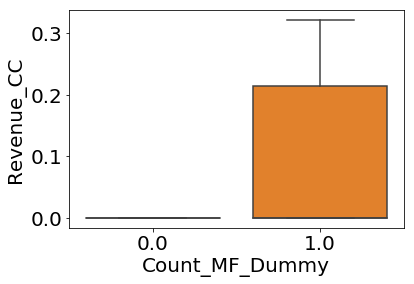

In [43]:

print('Number of clients with missing value Count_MF/ActBal_MF but having Sale_CC: ', end='')
Sale_MF_missing = train[(train.Count_CC_Dummy==0) & (train.Sale_CC==1)]
print(len(Sale_MF_missing))

b = sns.boxplot(x="Count_MF_Dummy", y="Revenue_CC", data=train, showfliers=False)
b.axes.set_title(" ", fontsize=font)
b.set_xlabel("Count_MF_Dummy",fontsize=font)
b.set_ylabel("Revenue_CC",fontsize=font)
b.tick_params(labelsize=font)

observed = train.Revenue_CC[train.Count_MF_Dummy==1]
missing = train.Revenue_CC[train.Count_MF_Dummy==0]
print('Number of samples in observed ', len(observed[observed >0]))
print('Number of samples in missing ', len(missing[missing >0]))

u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Tenure on")
print ("p value ", p_value)

Number of clients with missing value Count_MF/ActBal_MF but having Sale_CL: 259
Number of samples in observed  63
Number of samples in missing  227

two-sample wilcoxon-test Revenue_CL on
p value  0.103633312877


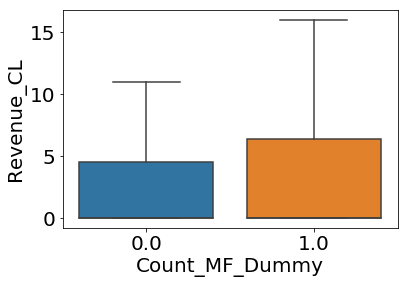

In [44]:

print('Number of clients with missing value Count_MF/ActBal_MF but having Sale_CL: ', end='')
Sale_MF_missing = train[(train.Count_CC_Dummy==0) & (train.Sale_CL==1)]
print(len(Sale_MF_missing))

b = sns.boxplot(x="Count_MF_Dummy", y="Revenue_CL", data=train, showfliers=False)
b.axes.set_title(" ", fontsize=font)
b.set_xlabel("Count_MF_Dummy",fontsize=font)
b.set_ylabel("Revenue_CL",fontsize=font)
b.tick_params(labelsize=font)

observed = train.Revenue_CL[train.Count_MF_Dummy==1]
missing = train.Revenue_CL[train.Count_MF_Dummy==0]
print('Number of samples in observed ', len(observed[observed >0]))
print('Number of samples in missing ', len(missing[missing >0]))

u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Revenue_CL on")
print ("p value ", p_value)


Number of clients who did not buy CC: 727
Number of clients with missing value Count_CC/ActBal_CC: 859
Number of clients with missing value Count_CC/ActBal_CC but having Sale_CC: 216
Number of samples in observed  26
Number of samples in missing  216

two-sample wilcoxon-test Revenue_CL on
p value  0.397825612534


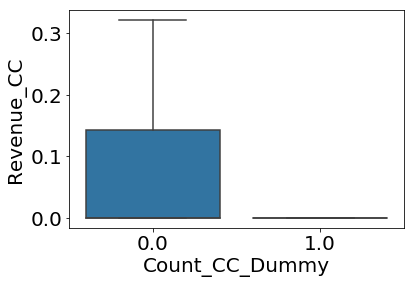

In [45]:
print('Number of clients who did not buy CC: ', end='')
print(len(train[train.Sale_CC==0]))

print('Number of clients with missing value Count_CC/ActBal_CC: ', end='')
print(len(train[train.Count_CC_Dummy==0]))

print('Number of clients with missing value Count_CC/ActBal_CC but having Sale_CC: ', end='')
Sale_CC_missing = train[(train.Count_CC_Dummy==0) & (train.Sale_CC==1)]
print(len(Sale_CC_missing))

b = sns.boxplot(x="Count_CC_Dummy", y="Revenue_CC", data=train, showfliers=False)
b.axes.set_title(" ", fontsize=font)
b.set_xlabel("Count_CC_Dummy",fontsize=font)
b.set_ylabel("Revenue_CC",fontsize=font)
b.tick_params(labelsize=font)

observed = train.Revenue_CC[train.Count_CC_Dummy==1]
missing = train.Revenue_CC[train.Count_CC_Dummy==0]
print('Number of samples in observed ', len(observed[observed >0]))
print('Number of samples in missing ', len(missing[missing >0]))
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Revenue_CL on")
print ("p value ", p_value)

Number of clients with missing value Count_CC/ActBal_CC but having Sale_CC: 171
Number of samples in observed  22
Number of samples in missing  171

two-sample wilcoxon-test Revenue_CL on
p value  0.465684481727


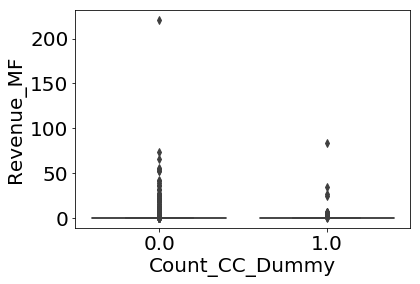

In [46]:
print('Number of clients with missing value Count_CC/ActBal_CC but having Sale_CC: ', end='')
Sale_CC_missing = train[(train.Count_CC_Dummy==0) & (train.Sale_MF==1)]
print(len(Sale_CC_missing))

b = sns.boxplot(x="Count_CC_Dummy", y="Revenue_MF", data=train)
b.set_xlabel("Count_CC_Dummy",fontsize=font)
b.set_ylabel("Revenue_MF",fontsize=font)
b.tick_params(labelsize=font)

observed = train.Revenue_MF[train.Count_CC_Dummy==1]
missing = train.Revenue_MF[train.Count_CC_Dummy==0]
print('Number of samples in observed ', len(observed[observed >0]))
print('Number of samples in missing ', len(missing[missing >0]))
u, p_value = stats.mannwhitneyu(observed, missing)
print ("\ntwo-sample wilcoxon-test Revenue_CL on")
print ("p value ", p_value)

Number of clients who did not buy CL: 679
Number of clients with missing value Count_CL/ActBal_CL: 890
Number of clients with missing value Count_CL/ActBal_CL but having Sale_CL: 181


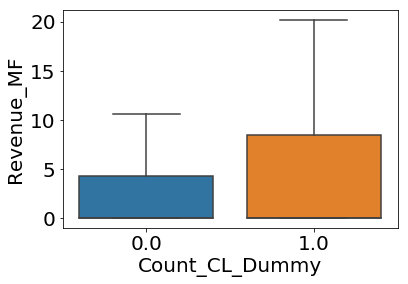

In [47]:
print('Number of clients who did not buy CL: ', end='')
print(len(train[train.Sale_CL==0]))

print('Number of clients with missing value Count_CL/ActBal_CL: ', end='')
print(len(train[train.Count_CL_Dummy==0]))

print('Number of clients with missing value Count_CL/ActBal_CL but having Sale_CL: ', end='')
Sale_CL_missing = train[(train.Count_CL_Dummy==0) & (train.Sale_MF==1)]
print(len(Sale_CL_missing))

b = sns.boxplot(x="Count_CL_Dummy", y="Revenue_CL", data=train, showfliers=False)
b.axes.set_title(" ", fontsize=font)
b.set_xlabel("Count_CL_Dummy",fontsize=font)
b.set_ylabel("Revenue_MF",fontsize=font)
b.tick_params(labelsize=font)

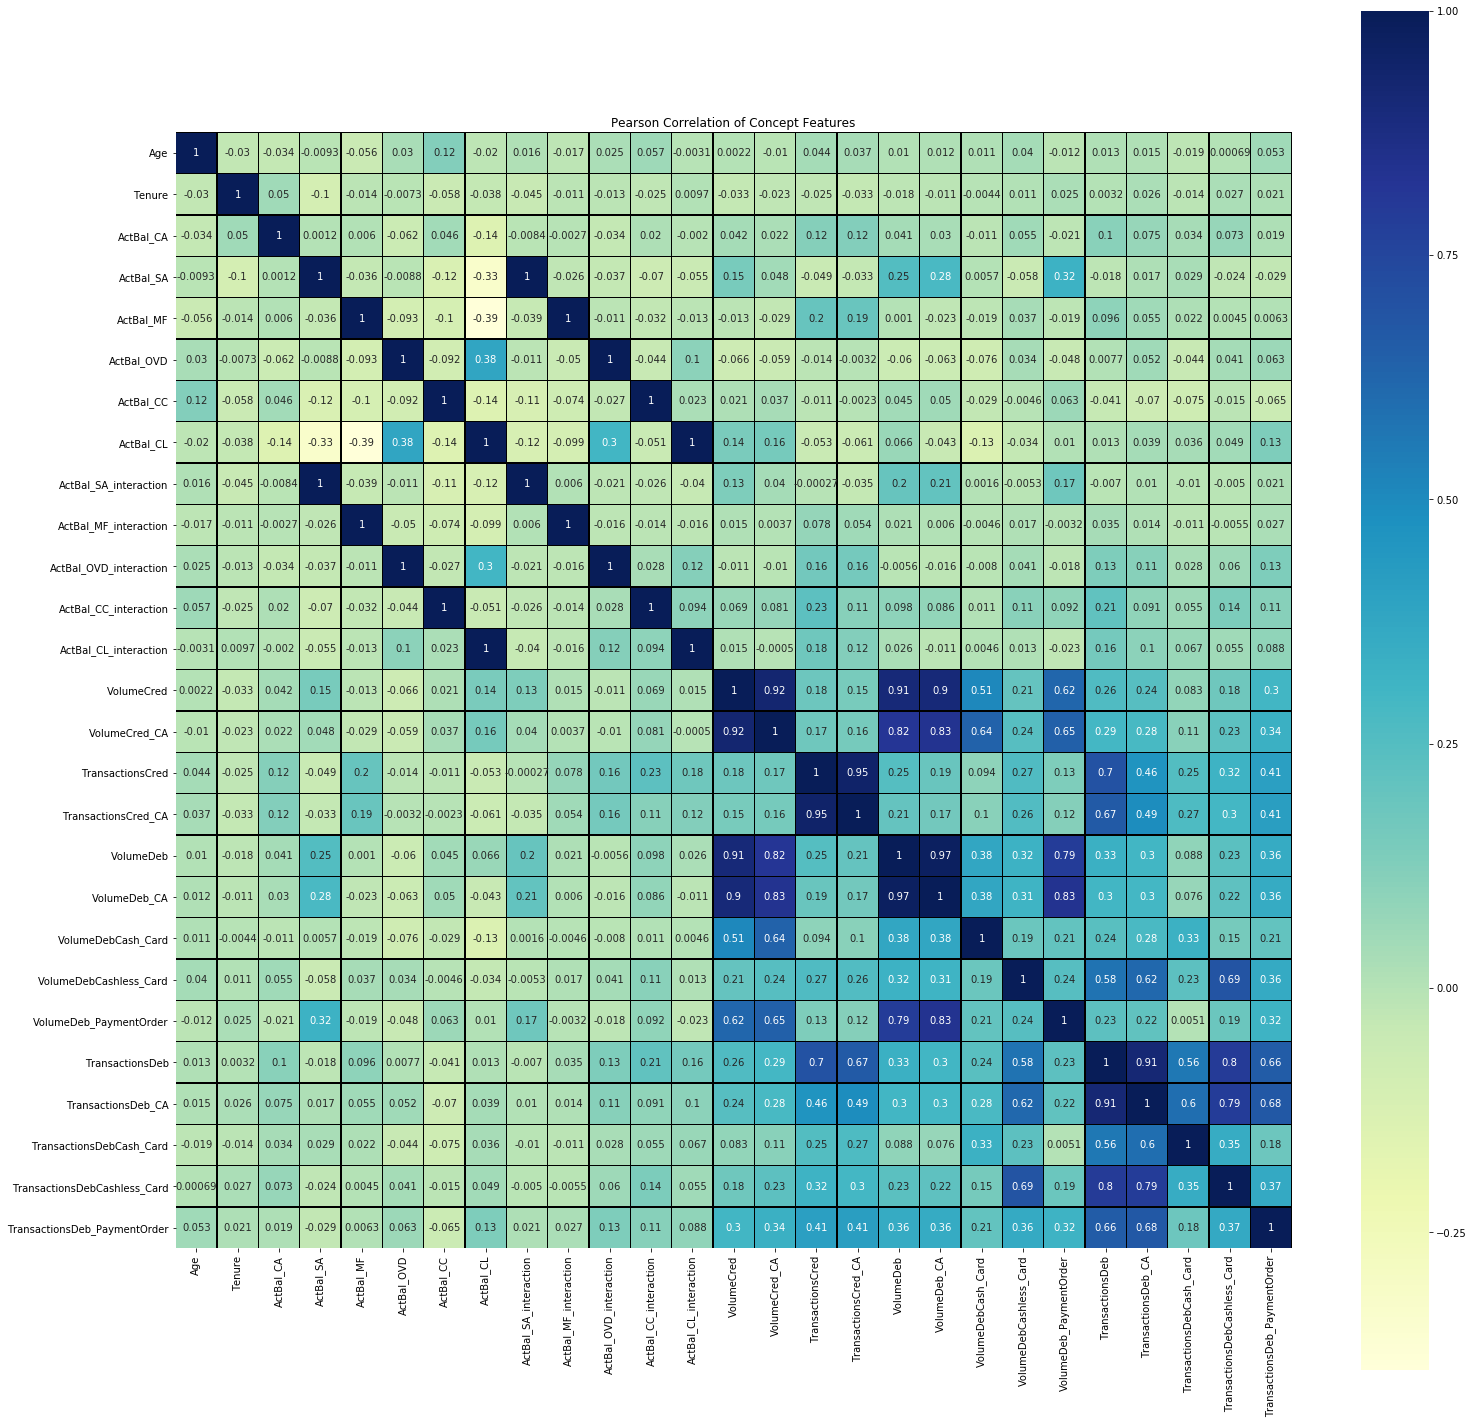

In [48]:
Columns_drop = ['Client', 'Count_CA','Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL','Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC','Revenue_CL', 'Sex','Count_SA_Dummy', 'Count_MF_Dummy','Count_CL_Dummy', 'Count_CC_Dummy', 'Count_OVD_Dummy']
train_corr = train.drop(Columns_drop, axis=1)
train_corr = train_corr[train_corr.columns.drop(list(train_corr.filter(regex='Dummy')))]
train_corr.columns

f, ax = plt.subplots(figsize=(25, 25))
plt.title('Pearson Correlation of Concept Features')
# Draw the heatmap using seaborn
sns.heatmap(train_corr.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)


C:\Users\elvis\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


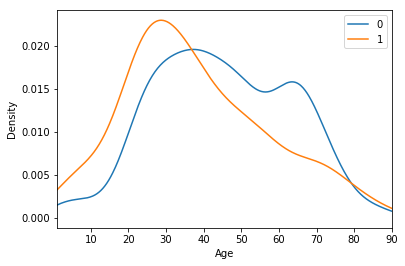

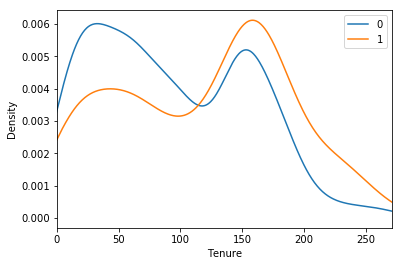

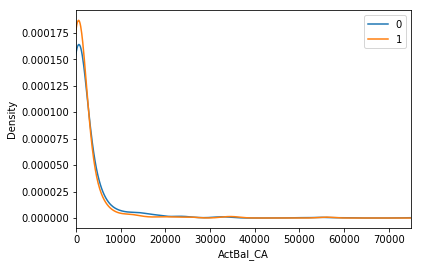

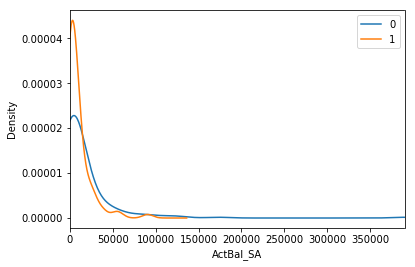

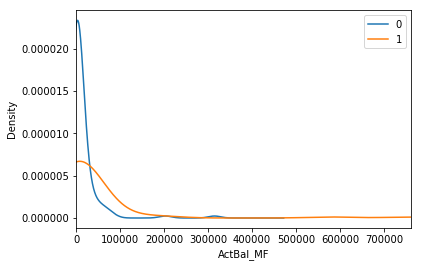

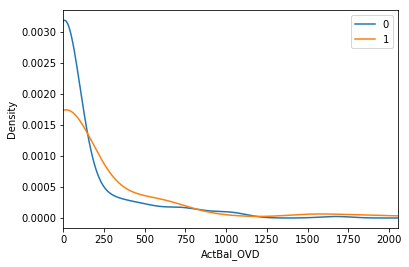

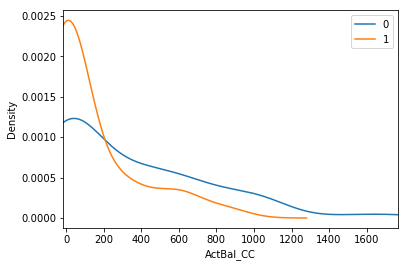

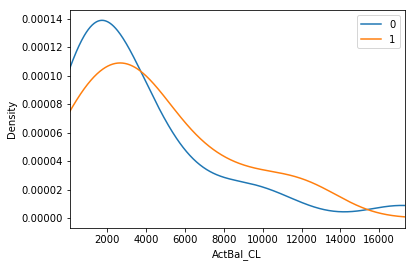

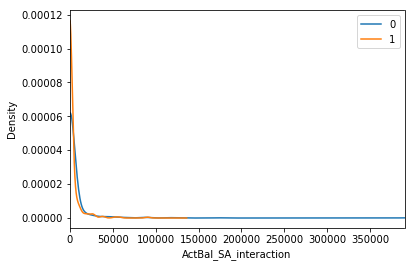

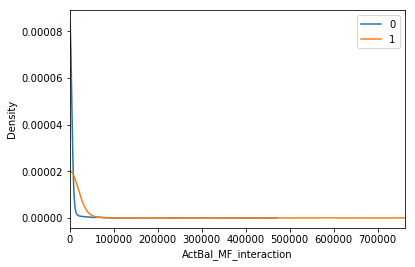

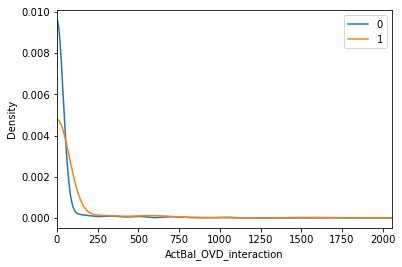

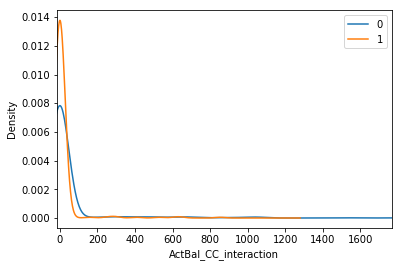

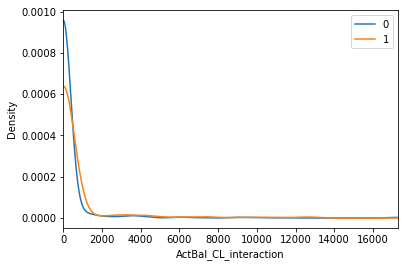

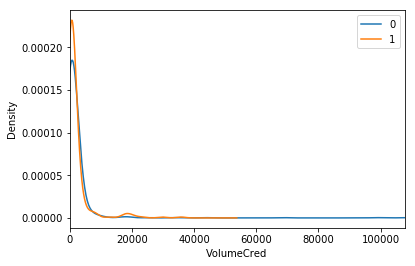

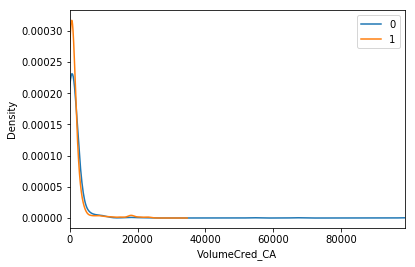

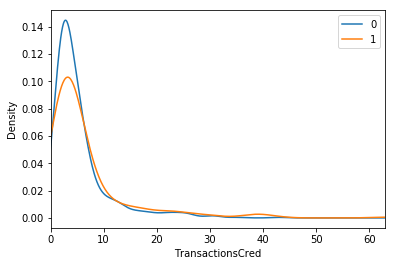

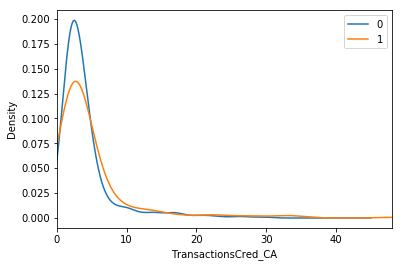

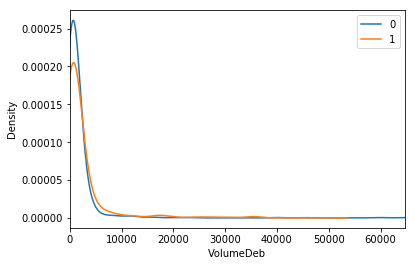

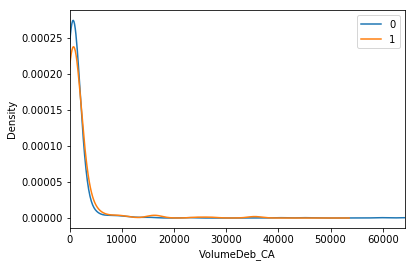

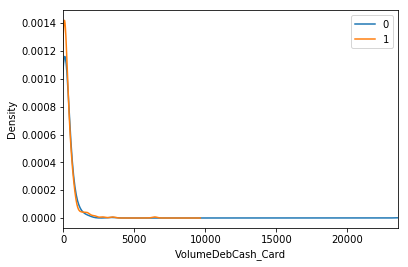

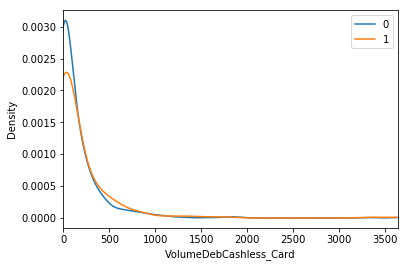

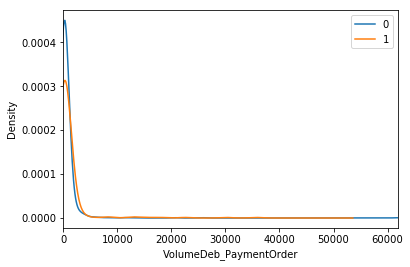

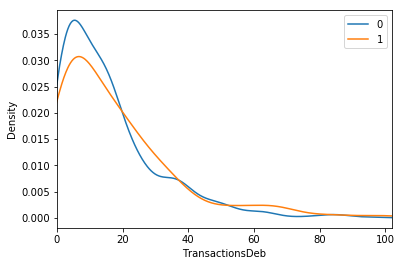

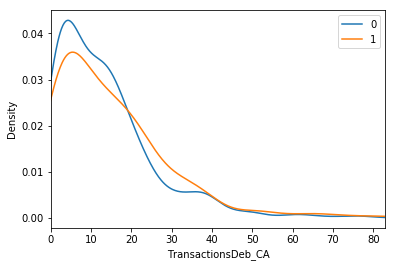

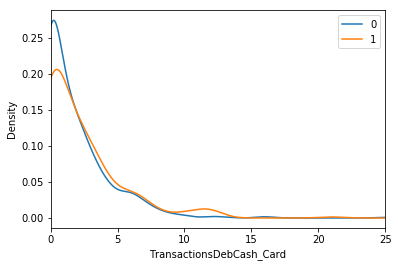

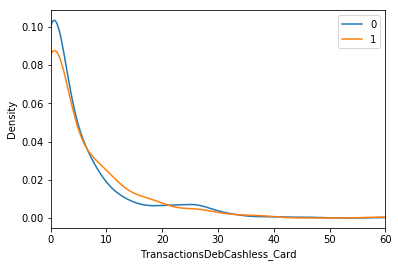

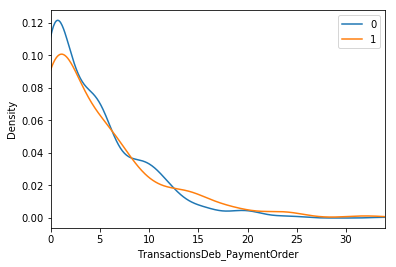

In [49]:
sub_cols = train_corr.columns
for colname in sub_cols:
    fig, ax = plt.subplots()
    ax.set_xlim(train_corr[colname].min(), train[colname].max())
    for group in train['Sale_CL'].unique():
        s = train[train['Sale_CL'] == group][colname]
        s.plot.kde(ax=ax,label=group)
        ax.set_xlabel(colname)
    ax.legend()

In [50]:
# Check independence on the indicator variables
columns_dummy = ['Count_SA_Dummy', 'Count_MF_Dummy', 'Count_OVD_Dummy','Count_CC_Dummy', 'Count_CL_Dummy','Sex_Dummy']
for i in range(len(columns_dummy)-1):
    col1 = columns_dummy[i]
    t = i+1
    for j in range(t,len(columns_dummy)):
        col2 = columns_dummy[j]
        cross_tab = pd.crosstab(train[col1], train[col2], margins = True)
        chi = stats.chi2_contingency(cross_tab)
        print("\n", col1, " against ", col2, "\tp value: ", chi[1])
        
# Count_SA_Dummy is correlated with Count_OVD_Dummy,Count_CL_Dummy and Count_CL_Dummy
# Count_MF_Dummy is correlated with Count_OVD_Dummy,Count_CL_Dummy and Count_CC_Dummy
# we only keep the values Count_SA_Dummy and Count_MF_Dummy and their corresponding interactions in the model
# Sex is independent of all variables


 Count_SA_Dummy  against  Count_MF_Dummy 	p value:  1.73425230171e-30

 Count_SA_Dummy  against  Count_OVD_Dummy 	p value:  0.995805249972

 Count_SA_Dummy  against  Count_CC_Dummy 	p value:  0.0216154676638

 Count_SA_Dummy  against  Count_CL_Dummy 	p value:  0.171270848183

 Count_SA_Dummy  against  Sex_Dummy 	p value:  0.888011883032

 Count_MF_Dummy  against  Count_OVD_Dummy 	p value:  0.817558670237

 Count_MF_Dummy  against  Count_CC_Dummy 	p value:  0.889888776257

 Count_MF_Dummy  against  Count_CL_Dummy 	p value:  0.122838535972

 Count_MF_Dummy  against  Sex_Dummy 	p value:  0.92228439374

 Count_OVD_Dummy  against  Count_CC_Dummy 	p value:  3.53292952987e-08

 Count_OVD_Dummy  against  Count_CL_Dummy 	p value:  1.64490693164e-05

 Count_OVD_Dummy  against  Sex_Dummy 	p value:  0.896893331113

 Count_CC_Dummy  against  Count_CL_Dummy 	p value:  4.22589505508e-07

 Count_CC_Dummy  against  Sex_Dummy 	p value:  0.999952378825

 Count_CL_Dummy  against  Sex_Dummy 	p value:  0.9

C:\Users\elvis\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


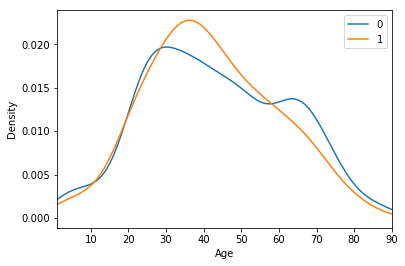

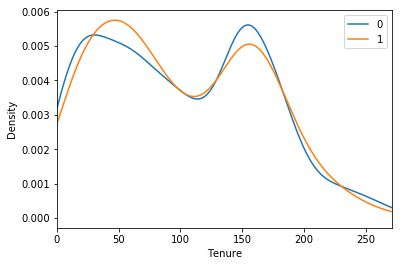

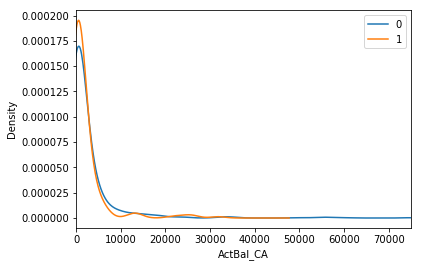

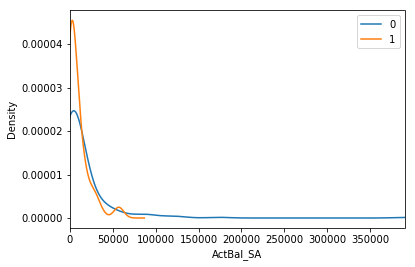

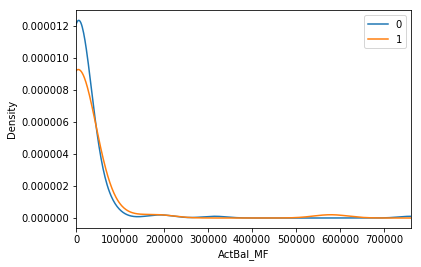

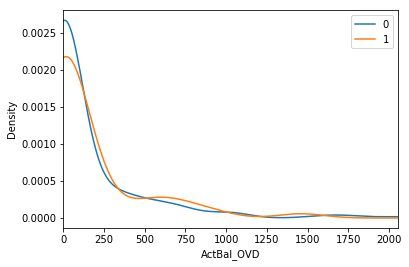

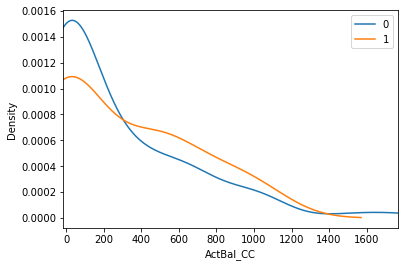

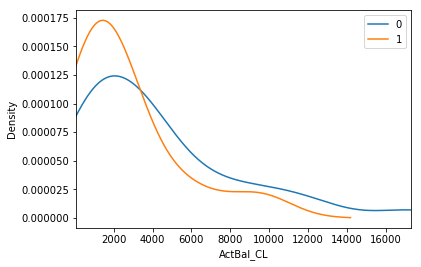

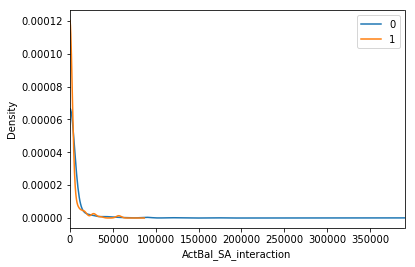

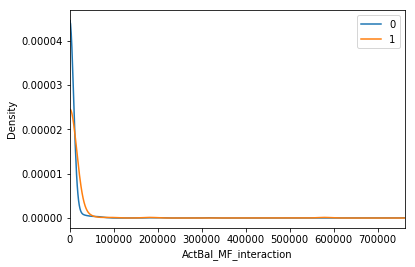

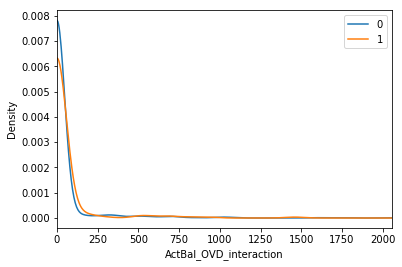

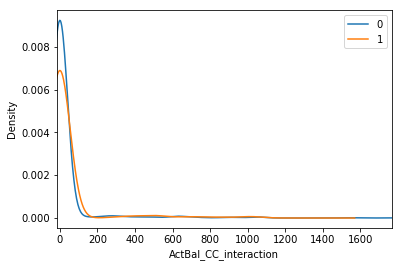

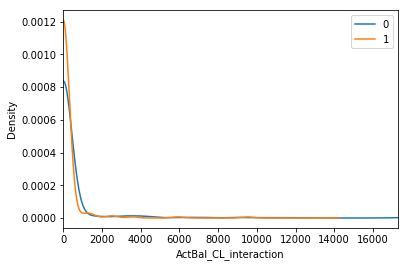

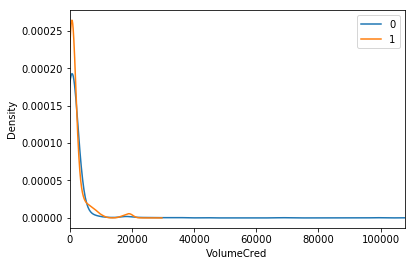

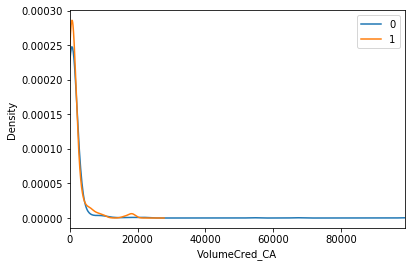

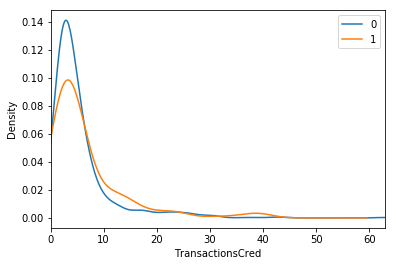

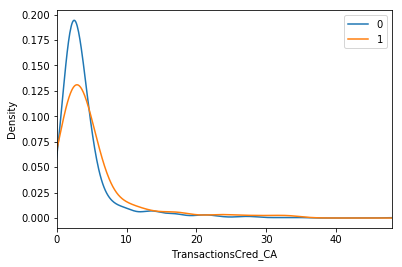

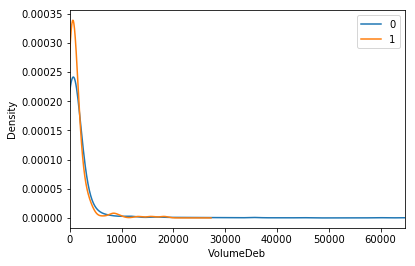

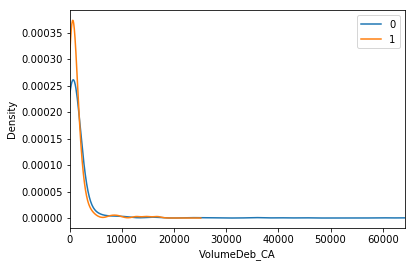

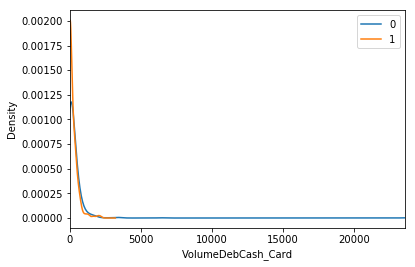

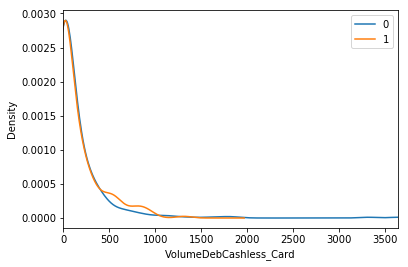

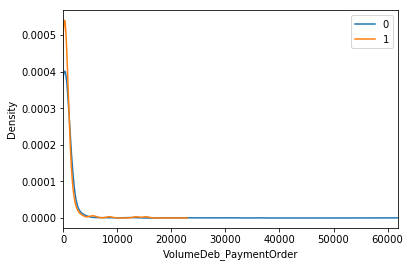

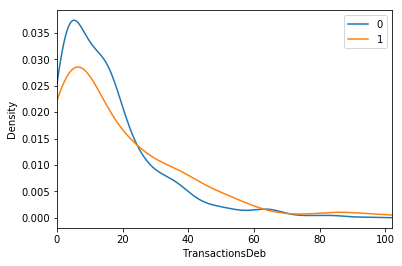

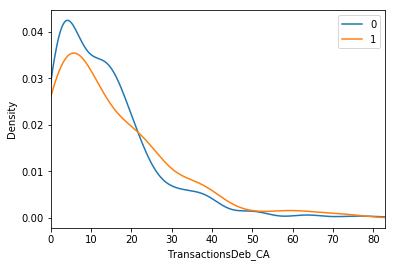

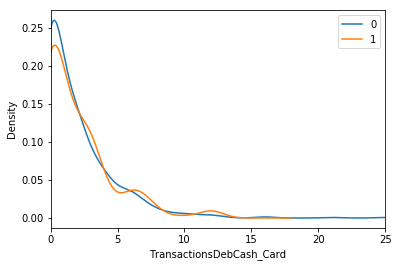

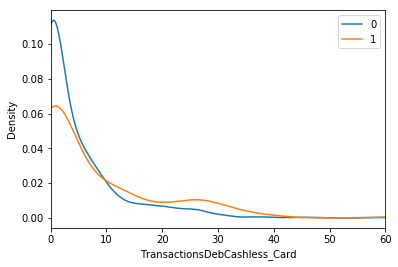

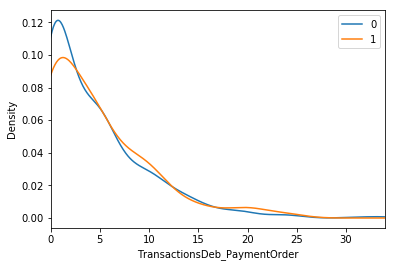

In [51]:
#Class specific distributions

sub_cols = train_corr.columns

for colname in sub_cols:
    fig, ax = plt.subplots()
    ax.set_xlim(train_corr[colname].min(), train[colname].max())
    for group in train['Sale_MF'].unique():
        s = train[train['Sale_MF'] == group][colname]
        s.plot.kde(ax=ax,label=group)
        ax.set_xlabel(colname)
    ax.legend()

C:\Users\elvis\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


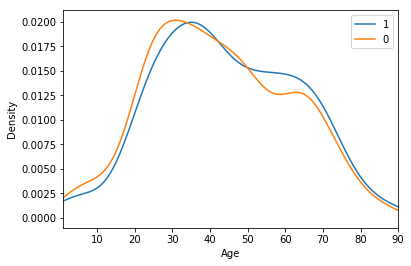

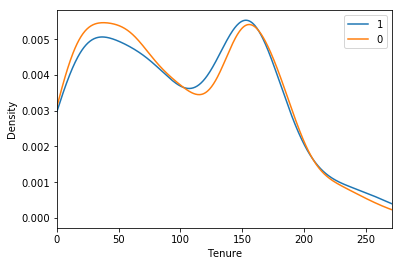

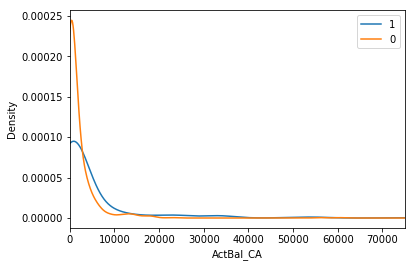

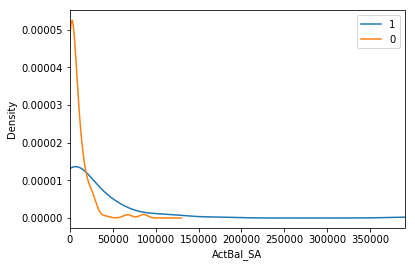

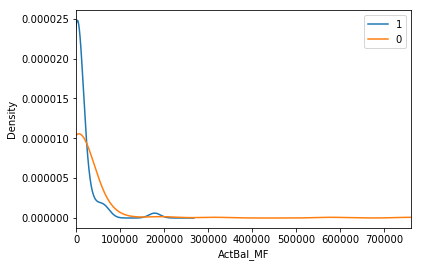

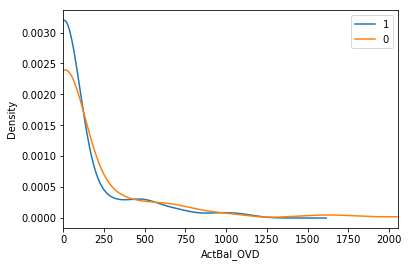

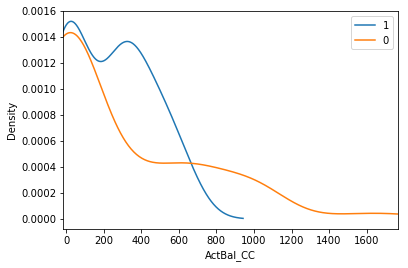

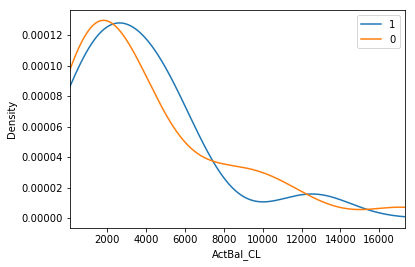

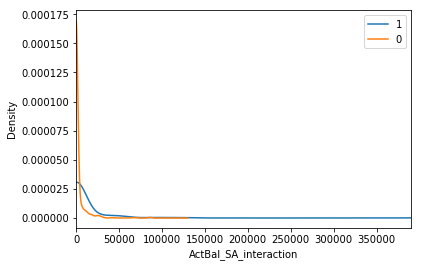

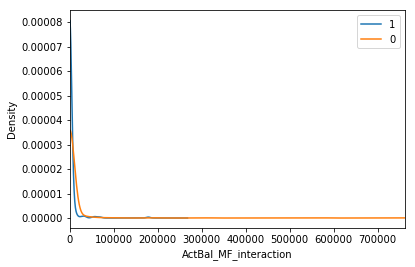

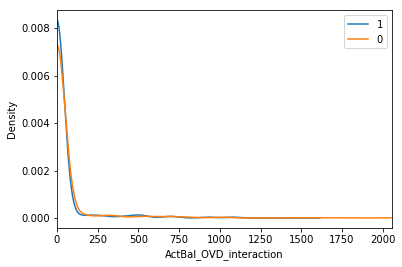

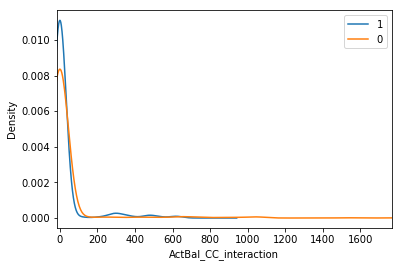

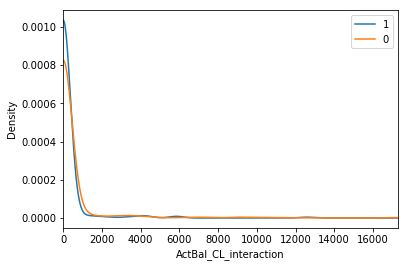

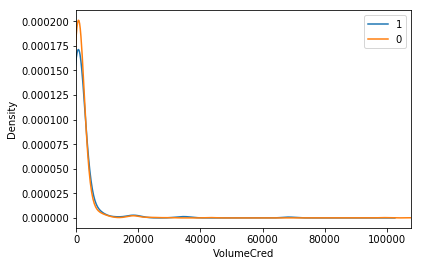

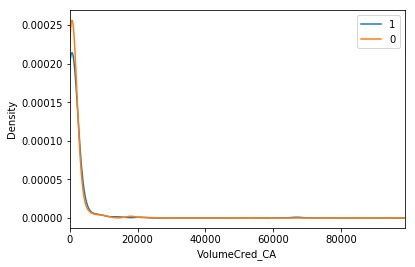

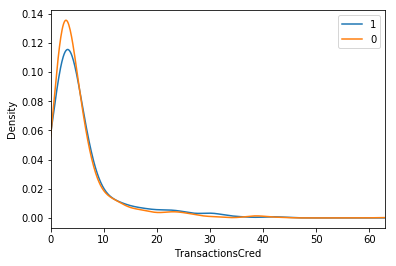

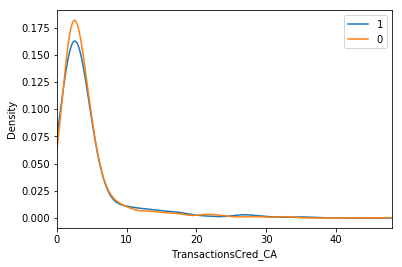

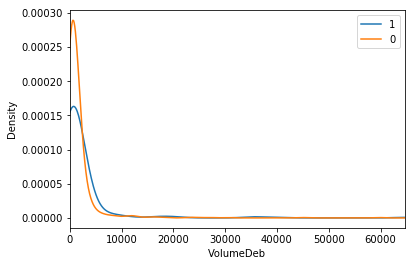

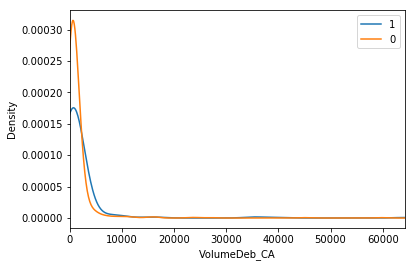

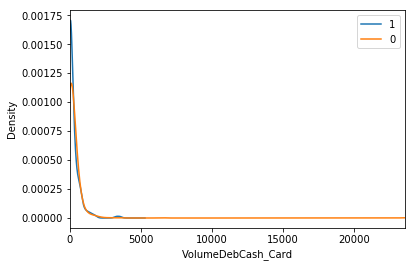

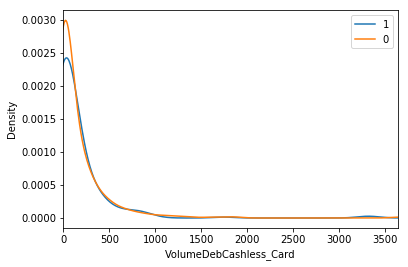

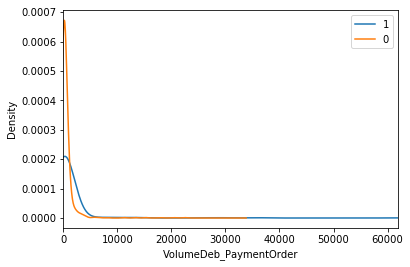

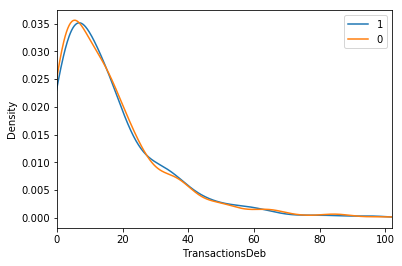

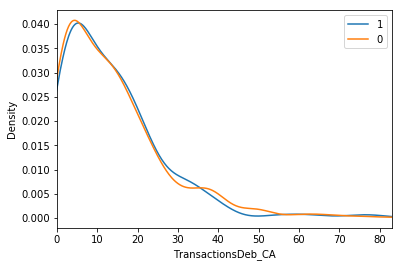

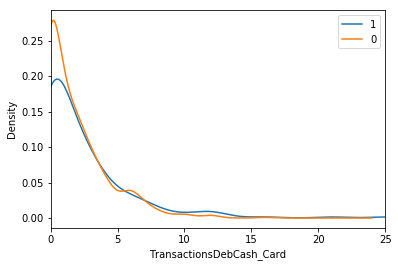

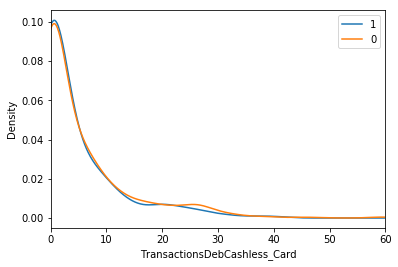

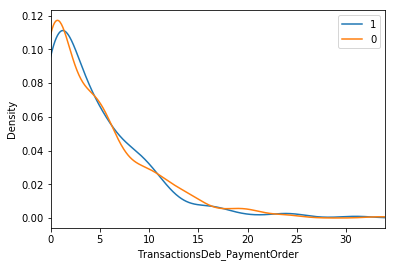

In [52]:
for colname in sub_cols:
    fig, ax = plt.subplots()
    ax.set_xlim(train_corr[colname].min(), train[colname].max())
    for group in train['Sale_CC'].unique():
        s = train[train['Sale_CC'] == group][colname]
        s.plot.kde(ax=ax,label=group)
        ax.set_xlabel(colname)
    ax.legend()

In [53]:
def plot_precision_recall(predicted, observed):
    precision, recall, _ = precision_recall_curve(predicted, observed)
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(average_precision))

In [54]:
y_MF = train.Sale_MF
X_train_MF, X_test_MF, y_train_MF, y_test_MF = train_test_split(train, y_MF, test_size=0.3, random_state=12345)
w = len(X_train_MF[y_train_MF==0])/len(X_train_MF[y_train_MF==1])

# Show the number of observations for the test and training dataframes
print('Number of observations in the training data: ', len(X_train_MF))
print('Number of observations in the test data: ',len(X_test_MF))

scale_feat_cont = ['ActBal_CA','ActBal_SA_interaction','ActBal_MF_interaction','VolumeDeb','VolumeCred','VolumeDebCash_Card','VolumeDebCashless_Card']
scale_feat_count = ['Age','Tenure','TransactionsCred','TransactionsDebCash_Card','TransactionsDeb_PaymentOrder']

# Standardize continuous variables standard scaler
scaler_stnd_MF = StandardScaler().fit(X_train_MF[scale_feat_cont])
X_train_MF.loc[:,scale_feat_cont] = scaler_stnd_MF.transform(X_train_MF[scale_feat_cont])                           
X_test_MF.loc[:,scale_feat_cont] = scaler_stnd_MF.transform(X_test_MF[scale_feat_cont])

# Standardize continuous variables standard scaler
scaler_minmax_MF = MinMaxScaler().fit(X_train_MF[scale_feat_count])
X_train_MF.loc[:,scale_feat_count] = scaler_minmax_MF.transform(X_train_MF[scale_feat_count])                           
X_test_MF.loc[:,scale_feat_count] = scaler_minmax_MF.transform(X_test_MF[scale_feat_count])

Number of observations in the training data:  678
Number of observations in the test data:  291

C:\Users\elvis\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Predicted    0  1
Observed         
0          227  6
1           53  5
Accuracy: 0.7973
Average precision-recall score: 0.22
f1_score: 0.14
Area Under Curve: 0.36


[('Age', 0.065037142805722592),
 ('Tenure', 0.050939537424916782),
 ('Count_CA', 0.010710216481681387),
 ('ActBal_CA', 0.072069048085143597),
 ('ActBal_SA_Dummy', 0.018041383358468464),
 ('ActBal_SA_interaction', 0.024089650567968413),
 ('ActBal_MF_Dummy', 0.017096154216233117),
 ('ActBal_MF_interaction', 0.015666714122931715),
 ('ActBal_OVD_Dummy', 0.007627232034180224),
 ('ActBal_OVD_interaction', 0.004594009786780727),
 ('ActBal_CC_Dummy', 0.0071074997999127799),
 ('ActBal_CC_interaction', 0.0087902961217154896),
 ('ActBal_CL_Dummy', 0.0043644218212602545),
 ('ActBal_CL_interaction', 0.005869288902222004),
 ('VolumeCred', 0.062663361472806753),
 ('VolumeCred_CA', 0.05571828062810992),
 ('TransactionsCred', 0.038042448740898745),
 ('TransactionsCred_CA', 0.033310537850415531),
 ('VolumeDeb', 0.080477971793210631),
 ('VolumeDeb_CA', 0.068697260691918963),
 ('VolumeDebCash_Card', 0.036397864390451),
 ('VolumeDebCashless_Card', 0.034679653916596512),
 ('VolumeDeb_PaymentOrder', 0.060172

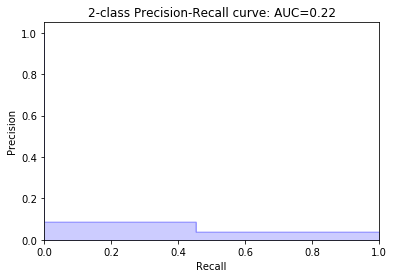

In [55]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

Columns_drop = ['Client','Sex','Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL','ActBal_SA','ActBal_CC','ActBal_MF','ActBal_CL','ActBal_OVD','Sale_MF', 'Sale_CC', 'Sale_CL', 'Revenue_MF', 'Revenue_CC','Revenue_CL', 'Sex','Count_SA_Dummy', 'Count_MF_Dummy','Count_CL_Dummy', 'Count_CC_Dummy', 'Count_OVD_Dummy']

X_train_MF_RF = X_train_MF.drop(Columns_drop, 1)
X_test_MF_RF =X_test_MF.drop(Columns_drop, 1) 

# Set random seed
np.random.seed(0)
clf = RandomForestClassifier()
clf.fit(X_train_MF_RF, y_train_MF)

predicted = clf.predict(X_test_MF_RF)

# Create confusion matrix
print(pd.crosstab(y_test_MF, predicted, rownames=['Observed'], colnames=['Predicted']))
print("Accuracy: %0.4f" % accuracy_score(y_test_MF,predicted))

average_precision = average_precision_score(y_test_MF,predicted)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
f1 = f1_score(y_test_MF,predicted)
print('f1_score: {0:0.2f}'.format(f1))

# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y_test_MF,predicted)
area = auc(recall, precision)
print("Area Under Curve: %0.2f" %area)
plot_precision_recall(predicted, y_test_MF)

list(zip(X_train_MF_RF, clf.feature_importances_))

# As expected tree based methods performed poorly due to high similarity between the distributions in most of the numeric variables


In [88]:
columns_VCred = ['Sex_Dummy','Age','Tenure','ActBal_CA','Count_SA_Dummy','Count_MF_Dummy','ActBal_SA_interaction','ActBal_MF_interaction','TransactionsCred','VolumeCred','VolumeDebCash_Card', 'VolumeDebCashless_Card','TransactionsDebCash_Card','TransactionsDeb_PaymentOrder']
products = ['Sale_MF', 'Sale_CC','Sale_CL']

X = train[columns_VCred]
ys = [train[p] for p in products]

classifiers = []
for i,p in enumerate(products):
    clf = ensemble.GradientBoostingClassifier(random_state=12345)
    clf.fit(X, ys[i])
    classifiers.append(clf)

In [89]:

train_outer = pd.merge(Sales_Revenues, market_data, on='Client', how='outer')
to_predict = train_outer[train_outer['Sale_MF'].isnull()]
to_predict = to_predict[columns_VCred]

predicted = [classifiers[i].predict(to_predict) for i in range(len(products))]
for i,p in enumerate(products):
    to_predict[p] = predicted[i]


In [90]:
offers = to_predict
offers["Client"] = train_outer[train_outer['Sale_MF'].isnull()]["Client"]
offers.head()

,Sex_Dummy,Age,Tenure,ActBal_CA,Count_SA_Dummy,Count_MF_Dummy,ActBal_SA_interaction,ActBal_MF_interaction,TransactionsCred,VolumeCred,VolumeDebCash_Card,VolumeDebCashless_Card,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Client
969,1,21.0,27,4.710714,0.0,0.0,0.0,0.000000,4,789.129643,178.571429,0.000000,1,4,0,0,0,909
970,1,37.0,175,1823.057143,0.0,1.0,0.0,18491.444286,8,1033.496071,89.285714,0.000000,2,5,0,0,0,699
971,0,19.0,70,0.000000,0.0,0.0,0.0,0.000000,2,435.682143,125.000000,70.842143,4,2,0,0,1,528
972,1,61.0,45,324.710000,0.0,0.0,0.0,0.000000,3,132.158929,0.000000,0.000000,0,0,0,0,0,1145
973,0,41.0,28,17.051071,0.0,0.0,0.0,0.000000,2,570.157857,71.428571,224.146429,2,3,0,0,0,517


In [91]:
offers.to_csv('offer_categorical.csv', index=False)

In [92]:
# Check number of client predicted to buy each product
a = offers[offers.Sale_MF == 1]
b = offers[offers.Sale_CC == 1]
c = offers[offers.Sale_CL == 1]
print("Number of new customers: %d" %len(offers))
print("Number of customers predicted to buy Mutaul fund: %d" %len(a))
print("Number of customers predicted to buy Credit card: %d" %len(b))
print("Number of customers predicted to buy Consumer Loan: %d" %len(c))

Number of new customers: 646
Number of customers predicted to buy Mutaul fund: 20
Number of customers predicted to buy Credit card: 66
Number of customers predicted to buy Consumer Loan: 81


In [93]:
offers["nb_products"] = offers.Sale_MF + offers.Sale_CC + offers.Sale_CL

abc = offers[offers.nb_products > 1]
print("We predicted that %d clients would buy more than one product" %len(abc))
abc = offers[offers.nb_products == 3]
print("We predicted that %d clients would buy all three products" %len(abc))

We predicted that 14 clients would buy more than one product
We predicted that 0 clients would buy all three products


In [94]:
train_outer = pd.merge(Sales_Revenues, market_data, on='Client', how='outer')
to_predict = train_outer[train_outer['Sale_MF'].isnull()]
to_predict = to_predict[columns_VCred]

predicted = [classifiers[i].predict_proba(to_predict)[:,1] for i in range(len(products))]
for i,p in enumerate(products):
    to_predict[p] = predicted[i]
    

In [95]:
offers_prob = to_predict
offers_prob["Client"] = train_outer[train_outer['Sale_MF'].isnull()]["Client"]
offers_prob.head()

,Sex_Dummy,Age,Tenure,ActBal_CA,Count_SA_Dummy,Count_MF_Dummy,ActBal_SA_interaction,ActBal_MF_interaction,TransactionsCred,VolumeCred,VolumeDebCash_Card,VolumeDebCashless_Card,TransactionsDebCash_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Client
969,1,21.0,27,4.710714,0.0,0.0,0.0,0.000000,4,789.129643,178.571429,0.000000,1,4,0.159942,0.151828,0.367691,909
970,1,37.0,175,1823.057143,0.0,1.0,0.0,18491.444286,8,1033.496071,89.285714,0.000000,2,5,0.298381,0.130949,0.297476,699
971,0,19.0,70,0.000000,0.0,0.0,0.0,0.000000,2,435.682143,125.000000,70.842143,4,2,0.105723,0.164556,0.752103,528
972,1,61.0,45,324.710000,0.0,0.0,0.0,0.000000,3,132.158929,0.000000,0.000000,0,0,0.201991,0.143142,0.140039,1145
973,0,41.0,28,17.051071,0.0,0.0,0.0,0.000000,2,570.157857,71.428571,224.146429,2,3,0.148636,0.276304,0.288544,517


In [96]:
# for each client find best product
products = ['Sale_MF', 'Sale_CC','Sale_CL']
all_clients = offers_prob.Client
best_offer = {}
best_probability = {}
best_product = {}

for client in all_clients:
    best_prod = products[0]
    prob1 = offers_prob[offers_prob.Client == client][best_prod]
    for p in products:
        prob2 = offers_prob[offers_prob['Client'] == client][p]
        if prob1.sum() < prob2.sum():
            prob1 = prob2
            best_prod = p
            
    best_offer[client] = {}
    best_offer[client]['prod'] = best_prod
    best_offer[client]['prob'] = prob1.sum()
    
    best_product[client] = best_prod
    best_probability[client] = prob1.sum()


In [97]:
items = [(v, k) for k, v in best_probability.items()]
items.sort()
items.reverse()             # so largest is first
items = [(k, v) for v, k in items]

In [98]:
target_offers = pd.DataFrame(columns=('Client', 'Product'))
i = 1
for v, k in items:
    #print(v, " ", k, " ", best_product[v])
    target_offers.loc[i] = [v,best_product[v]]
    i = i + 1
    
print(target_offers.head())

  Client  Product
1    197  Sale_CC
2    697  Sale_CL
3    535  Sale_CC
4    587  Sale_CC
5   1227  Sale_CC


In [99]:
target_offers.head(n=100).to_csv('targeted_offers.csv', index=False)